# DAT 402 Project 2

# Plant Disease Detection from Leaf Images

---

#### Team Members:
- Pete VanBenthuysen
- Emily Szolnoki
---

#### Project Goal:
The goal of this project is to predict whether a plant — specifically bell pepper, potato, or tomato — is healthy or afflicted by a specific disease based on an image of its leaf.
Rather than simply detecting the presence of disease, the model is designed to identify the exact type of illness, enabling farmers to make informed decisions about whether a plant is salvageable, treatable, or needs to be removed.

This project leverages deep learning to create a rapid, low-cost diagnostic tool for agriculture.
Early and accurate detection of plant diseases in these critical crops is essential for preventing crop loss, maintaining food supply chains, and promoting sustainable farming practices.

Traditional methods of diagnosing plant diseases can be slow, require expert knowledge, and are often inaccessible to farmers in rural or resource-limited settings.
By training a convolutional neural network (CNN) on a large dataset of real-world agricultural images, we aim to automate disease identification across a wide range of conditions with high accuracy.

This project demonstrates how machine learning can transform agriculture by making expert-level diagnostics accessible to everyone — helping farmers make faster, more informed decisions, reduce unnecessary pesticide use, improve crop yields, and enhance global food security.
It also opens pathways for building mobile applications or embedded systems that bring AI-powered diagnostics directly into the hands of agricultural workers worldwide.

---

#### Dataset:
We are using the "PlantVillage" dataset, sourced from Kaggle.  
The dataset contains over 20,000 labeled images of plant leaves, specifically focusing on three crops: bell peppers, potatoes, and tomatoes.
Each image is classified into one of 15 categories, representing either a specific disease or a healthy leaf.
The dataset is organized into folders based on the class label, with each folder containing images for a particular disease or healthy condition.
There are no missing values.
However, the distribution of images across classes is imbalanced, with certain diseases (such as Tomato Yellow Leaf Curl Virus) having significantly more samples than others (such as Potato healthy).

You can download the dataset [Here.](https://www.kaggle.com/datasets/emmarex/plantdisease)

After downloading, extract the contents into the `data/` folder of the project, preserving the folder structure.

In [1]:
# System and Path Management
import sys
from pathlib import Path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress TensorFlow warnings

# Add src/ to sys.path
src_path = Path(os.getcwd()).resolve().parent / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import shutil
import io
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
import collections

# Basic Libraries
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from PIL import Image
import cv2
import IPython.display as ipd

# Data Preprocessing and Augmentation
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# Machine Learning Models and Metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# Deep Learning Libraries (TensorFlow/Keras)
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2

# Deep Learning Libraries (PyTorch)
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Model Persistence
import joblib

# Project-Specific Modules
import config
print(f"Using config from: {config.__file__}")
print(f"DATA_DIR path: {config.DATA_DIR}")

from functions import (
    count_images_per_class,
    plot_rf_class_distribution,
    plot_cnn_class_distribution,
    is_valid_file,
    print_class_distribution_with_names,
    plot_class_distribution,
    load_images_and_labels,
    group_and_report_crop_distribution,
    is_folder_complete,
    apply_transformations_and_save,
    extract_and_pivot_gridsearch_train,
    plot_rf_confusion_matrix_train,
    plot_rf_heatmap_train,
    save_rf_gridsearch_metadata_train,
    evaluate_and_visualize_model,
    build_improved_cnn_model,
    tta_predict,
    save_cnn_metrics_to_json,
    save_model_summary_arch_weights,
    plot_rf_confusion_matrix_test,
    plot_rf_probabilities_heatmap_test,
    plot_rf_feature_importance_test,
    plot_confusion_matrix_cnn_test,
    plot_prediction_explanation_grid,
    plot_cnn_probabilities_heatmap_test,
    plot_crop_distribution,
    apply_leaf_mask,
    mask_and_save_all_images,
    is_split_complete,
    save_cnn_split,
    show_random_images,
    plot_compressed_scatter,
    plot_cluster_scatter,
    plot_autoencoder_loss_curve,
    plot_bottleneck_vs_loss,
    plot_final_autoencoder_loss,
    build_autoencoder,
    plot_top20_gridsearch_models,
    plot_training_curves,
    generate_predictions,
    plot_confusion_matrix,
    visualize_predictions,
    generate_gradcam_visualizations
)




[CONFIG] DATA_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\data
[CONFIG] MASKED_DATA_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\masked_data
[CONFIG] OUTPUTS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs
[CONFIG] RF_SPLITS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_rf
[CONFIG] CNN_SPLITS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn_transformed
[CONFIG] CNN_VAL_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\val
[CONFIG] CNN_TEST_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\test
[CONFIG] RF_TEST_RESULTS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf
Using config from: C:\Users\petev\OneDrive\Desktop\LeafLens\src\config.py
DATA_DIR path: C:\Users\petev\OneDrive\Desktop\LeafLens\data


We begin by importing all essential libraries for data handling, visualization, machine learning, and deep learning. This also includes custom utility functions from `functions.py` and predefined directory paths from `config.py`. This modular structure promotes maintainability, consistency, and reliable access to shared components across the entire project pipeline.

In [2]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cpu


Next, we check for GPU availability to accelerate model training. To ensure reproducibility across multiple runs, we also set random seeds for `torch`, `numpy`, and Python's `random` module early in the workflow. This controls stochastic processes such as data splitting, model initialization, and sampling, enabling consistent and comparable results across experiments [1].*

###### **\*** **Note:** While we set fixed random seeds using `torch.manual_seed(42)`, `np.random.seed(42)`, and `random.seed(42)` to promote reproducibility, minor variations can still occur between runs due to non-deterministic behavior in certain libraries (especially in GPU-backed operations or parallelized processes). These differences are expected and typically have negligible impact on overall results.

###### [1] [PyTorch Reproducibility Guide](https://pytorch.org/docs/stable/notes/randomness.html)

In [3]:
# Define the path to the main PlantVillage folder
base_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "PlantVillage"))

# Define the path to the duplicate PlantVillage folder
duplicate_path = os.path.join(base_path, "PlantVillage")

# Check if the duplicate folder exists
if os.path.exists(duplicate_path):
    print(f"Duplicate folder found at: {duplicate_path}")
    # Remove the duplicate folder and its contents
    shutil.rmtree(duplicate_path)
    print(f"Duplicate folder removed: {duplicate_path}")
else:
    print(f"No duplicate folder found at: {duplicate_path}")

No duplicate folder found at: c:\Users\petev\OneDrive\Desktop\LeafLens\data\PlantVillage\PlantVillage


#### Quality Checks

Before inspecting the shape of our data, we check to make sure no duplicate folders exist. If they do and their contents are the same, it is deleted.

In [4]:
# List categories (subfolders inside PlantVillage)
categories = sorted([folder.name for folder in config.PLANT_VILLAGE_PATH.iterdir() if folder.is_dir()])
print(f"Number of categories (classes): {len(categories)}")
print("Classes:", categories)

# Save class names to a JSON file
with open(config.OUTPUTS_DIR / "class_names.json", "w") as f:
    json.dump(categories, f)
print(f"Saved class names to {config.OUTPUTS_DIR / 'class_names.json'}")

# Load images and labels
images, labels, skipped_images = load_images_and_labels(config.PLANT_VILLAGE_PATH, categories)

# Print basic dataset characteristics
print(f"\nTotal images loaded: {images.shape[0]}")
print(f"Each image shape: {images.shape[1:]} (Height x Width x Channels)")
print(f"Labels shape: {labels.shape}")

# Print skipped images summary
print("\n--- Skipped Images Summary ---")
for category, count in skipped_images.items():
    print(f"Category '{category}': {count} images skipped")

Number of categories (classes): 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Saved class names to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\class_names.json
Skipped invalid image C:\Users\petev\OneDrive\Desktop\LeafLens\data\PlantVillage\Tomato__Tomato_YellowLeaf__Curl_Virus\svn-r6Yb5c under category 'Tomato__Tomato_YellowLeaf__Curl_Virus': cannot identify image file 'C:\\Users\\petev\\OneDrive\\Desktop\\LeafLens\\data\\PlantVillage\\Tomato__Tomato_YellowLeaf__Curl_Virus\\svn-r6Yb5c'

Total images loaded: 20638
Each image shape: (128, 128, 3) (Height x Width x Channels)
Labels shape: (20638,)

--- Skipped Image

#### Data Loading and Cleaning Steps

- For each class, all files within its subfolder were iterated.
- Only valid image files (non-directories) were processed.
- Images were opened with the Pillow (PIL) library, converted to RGB, and resized to 128×128 pixels [2].
- Invalid or unreadable files (e.g., corrupted or non-image files) were safely skipped without interrupting the loading process.
- Skipped images were tracked per category for auditing purposes.
- Saved class_names as a json file for future reference [3].

#### Dataset Description

The PlantVillage dataset is organized into 15 distinct classes, with each class represented as a subfolder under the `PlantVillage` directory.  
Each subfolder corresponds to a specific plant disease or a healthy plant condition across bell peppers, potatoes, and tomatoes.

#### Dataset Characteristics

- Total of 20,638 valid images successfully loaded.
- Each image is a NumPy array of shape (128, 128, 3).
- Labels were assigned as integer IDs (0–14) based on the alphabetical order of class names.

###### [2] [Pillow Documentation](https://realpython.com/image-processing-with-the-python-pillow-library/) 
###### [3] [JSON syntax](https://docs.python.org/3/library/json.html)


--- Observations ---
The dataset covers 15 different plant disease and healthy categories, primarily across bell peppers, potatoes, and tomatoes.
Images are consistently resized to 128x128 pixels with 3 color channels (RGB).

--- Grouped Class Distribution ---

--- Potato Dataset ---
Healthy: 152 images
Infected (Potato___Early_blight): 1000 images
Infected (Potato___Late_blight): 1000 images


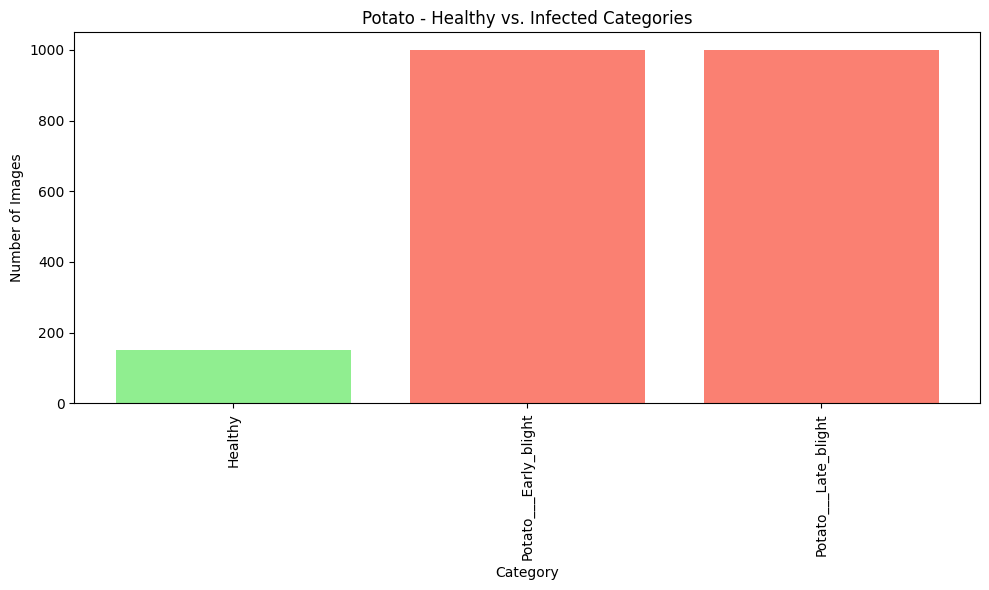


--- Pepper Dataset ---
Healthy: 1478 images
Infected (Pepper__bell___Bacterial_spot): 997 images



--- Tomato Dataset ---
Healthy: 1591 images
Infected (Tomato_Bacterial_spot): 2127 images
Infected (Tomato_Early_blight): 1000 images
Infected (Tomato_Late_blight): 1909 images
Infected (Tomato_Leaf_Mold): 952 images
Infected (Tomato_Septoria_leaf_spot): 1771 images
Infected (Tomato_Spider_mites_Two_spotted_spider_mite): 1676 images
Infected (Tomato__Target_Spot): 1404 images
Infected (Tomato__Tomato_YellowLeaf__Curl_Virus): 3208 images
Infected (Tomato__Tomato_mosaic_virus): 373 images


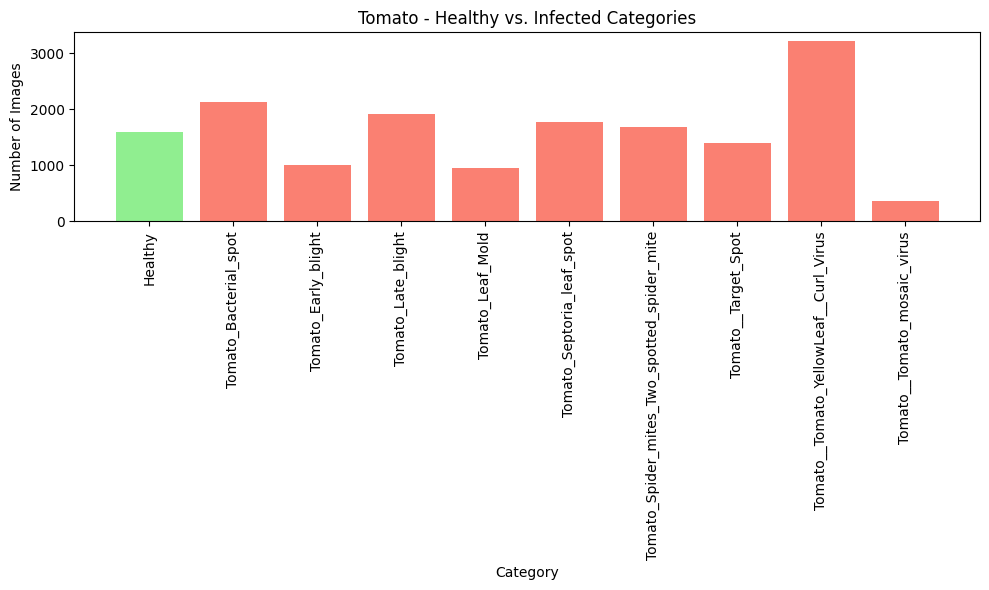

Saved plot to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\potato_distribution.png


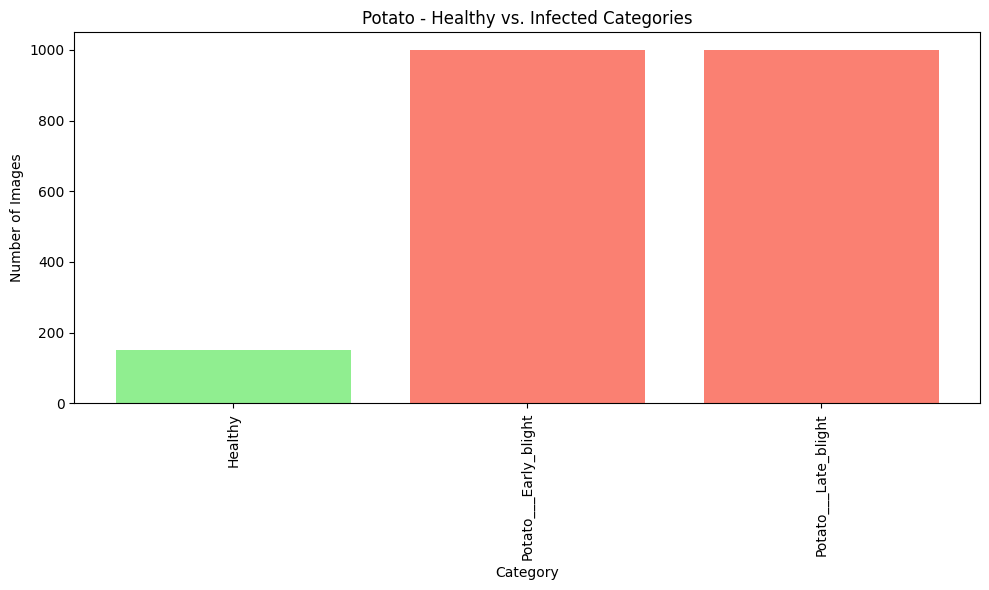

Saved plot to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\pepper_distribution.png


Saved plot to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\tomato_distribution.png


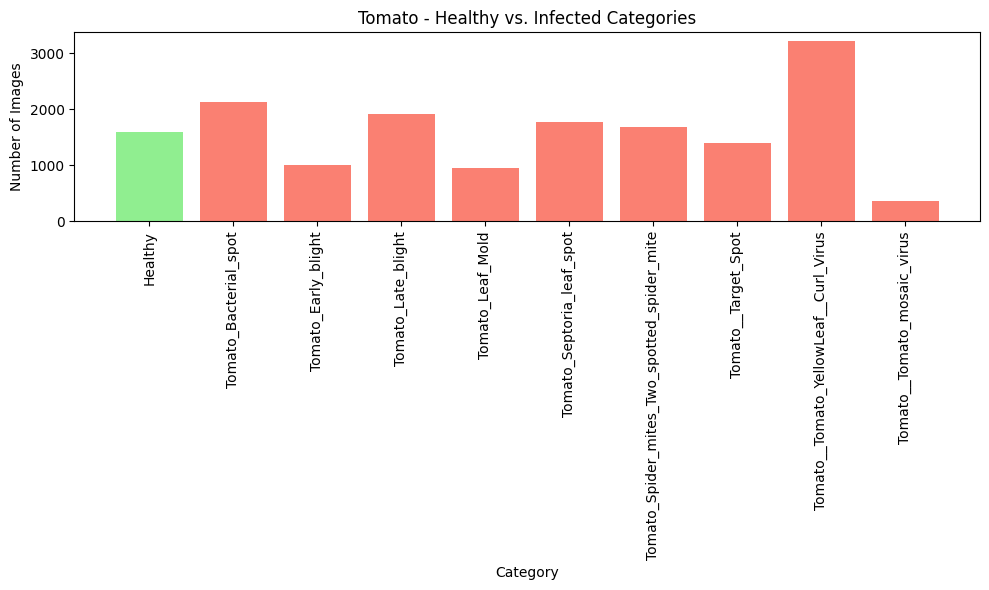

In [5]:
# Plot a bar chart of class distribution
plot_class_distribution(
    labels,
    categories,
    title="Original Dataset Distribution",
    save_path=config.EDA_DIR / "original_dataset_distribution.png"
)

# Print observations
print("\n--- Observations ---")
print(f"The dataset covers {len(categories)} different plant disease and healthy categories, primarily across bell peppers, potatoes, and tomatoes.")
print("Images are consistently resized to 128x128 pixels with 3 color channels (RGB).")

# Print grouped class distribution
print("\n--- Grouped Class Distribution ---")
labels_df = pd.DataFrame({'label': labels})
class_counts = labels_df['label'].value_counts().sort_index()

# Count healthy and infected images for each crop
crops = group_and_report_crop_distribution(class_counts, categories, plot_func=plot_crop_distribution)

# Save each crop's distribution plot to outputs/EDA
eda_dir = config.EDA_DIR 
eda_dir.mkdir(parents=True, exist_ok=True)

for crop_name, crop_data in crops.items():
    save_path = eda_dir / f"{crop_name.lower().replace(' ', '_')}_distribution.png"
    plot_crop_distribution(crop_name, crop_data, save_path=save_path)

#### Observations

- The dataset exhibits a class imbalance, with diseases like *Tomato Yellow Leaf Curl Virus* overrepresented compared to others like *Potato Healthy*. 
- Addressing class imbalance during model training (e.g., through data augmentation or class-weighted loss) is important to prevent bias.
- The dataset is rich, diverse, and well-structured, providing a strong foundation for developing machine learning models, particularly Convolutional Neural Networks (CNNs) for image classification tasks.

In [6]:
"""
# Mask all images
mask_and_save_all_images()

# List categories for masked data
categories = sorted([folder.name for folder in (config.MASKED_DATA_DIR / "PlantVillage").iterdir() if folder.is_dir()])

# Load masked images and labels (already returns np.array)
images, labels = load_images_and_labels_from_path(config.MASKED_DATA_DIR / "PlantVillage", categories)

print(f"Loaded {len(images)} masked images.")
print(f"Unique classes found: {len(np.unique(labels))}")

config.MASKED_ARRAYS_DIR.mkdir(parents=True, exist_ok=True)
np.save(config.MASKED_ARRAYS_DIR / 'images.npy', images)
np.save(config.MASKED_ARRAYS_DIR / 'labels.npy', labels)
"""

'\n# Mask all images\nmask_and_save_all_images()\n\n# List categories for masked data\ncategories = sorted([folder.name for folder in (config.MASKED_DATA_DIR / "PlantVillage").iterdir() if folder.is_dir()])\n\n# Load masked images and labels (already returns np.array)\nimages, labels = load_images_and_labels_from_path(config.MASKED_DATA_DIR / "PlantVillage", categories)\n\nprint(f"Loaded {len(images)} masked images.")\nprint(f"Unique classes found: {len(np.unique(labels))}")\n\nconfig.MASKED_ARRAYS_DIR.mkdir(parents=True, exist_ok=True)\nnp.save(config.MASKED_ARRAYS_DIR / \'images.npy\', images)\nnp.save(config.MASKED_ARRAYS_DIR / \'labels.npy\', labels)\n'

#### Masking Data

The purpose of masking is to reduce background noise and emphasize the most relevant features within an image — typically the object of interest, such as a leaf. For convolutional neural networks (CNNs), which learn spatial hierarchies of patterns, unmasked backgrounds can introduce misleading textures or shapes that detract from accurate feature learning. For random forest (RF) models, which rely on engineered features from pixel intensities or compressed representations, background noise can dilute the signal by adding irrelevant variance.

In our case, the dataset consisted of images with clean, uniform backgrounds, so explicit masking was not necessary during initial training. However, the project pipeline is designed to support masked inputs. If future datasets contain more complex or noisy backgrounds, the model can be retrained with masked data to enhance robustness and generalization to new environments [4].

###### [4] [Image Masking in Deep Learning](https://retouchinglabs.com/what-is-the-purpose-of-image-masking-in-deep-learning/)

In [7]:
# Check the number of images and labels
print(f"Number of images: {images.shape[0]}")
print(f"Number of labels: {len(labels)}")

# Ensure the number of labels matches the number of images
assert len(labels) == images.shape[0], "Mismatch between the number of images and labels"

# Flatten and normalize pixel values
X_flat = images.reshape(images.shape[0], -1) / 255.0
print(f"Shape after flattening: {X_flat.shape}")

# Split for training the Autoencoder
train_images, val_images = train_test_split(X_flat, test_size=0.2, random_state=42)

Number of images: 20638
Number of labels: 20638
Shape after flattening: (20638, 49152)


#### Preprocess and Flatten Image Data

We begin by verifying that the number of images matches the number of labels, then flatten each image into a one-dimensional vector and normalize pixel values to the [0, 1] range. This preprocessing step prepares the image data to be fed into an autoEncoder.

Instead of using PCA (Principal Component Analysis) for dimensionality reduction, we use an autoEncoder — a type of unsupervised neural network that learns to compress and reconstruct data through non-linear transformations. While PCA performs linear projection onto orthogonal components, an autoEncoder is capable of capturing non-linear relationships and complex data structures, making it more suitable for high-dimensional image data like ours [5].

The encoder part of the autoEncoder learns to map the original high-dimensional image into a compact bottleneck vector, which preserves the most essential features needed to reconstruct the input. This bottleneck is later used as a compressed representation of the image, which can be input into downstream machine learning models like Random Forest or XGBoost.

Using an autoEncoder allows us to retain spatial and texture-based information that PCA might miss, especially in cases where disease patterns are subtle and non-linearly distributed across the leaf surface [6].

###### [5] [PCA vs. AutoEncoders](https://medium.com/data-science/dimensionality-reduction-with-autoencoders-versus-pca-f47666f80743)
###### [6] [Dimensionality Reducuction using AutoEncoders in Python](https://www.analyticsvidhya.com/blog/2021/06/dimensionality-reduction-using-autoencoders-in-python/)

Training Autoencoder with bottleneck_dim = 100
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 440ms/step - loss: 0.0296 - val_loss: 0.0242
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - loss: 0.0229 - val_loss: 0.0199
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 399ms/step - loss: 0.0195 - val_loss: 0.0183
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 398ms/step - loss: 0.0185 - val_loss: 0.0177
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 395ms/step - loss: 0.0176 - val_loss: 0.0173
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - loss: 0.0164 - val_loss: 0.0161
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 399ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step - loss: 0.0156 - val_loss: 0.0157
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 395ms/step - loss: 0.0152 - val_loss: 0

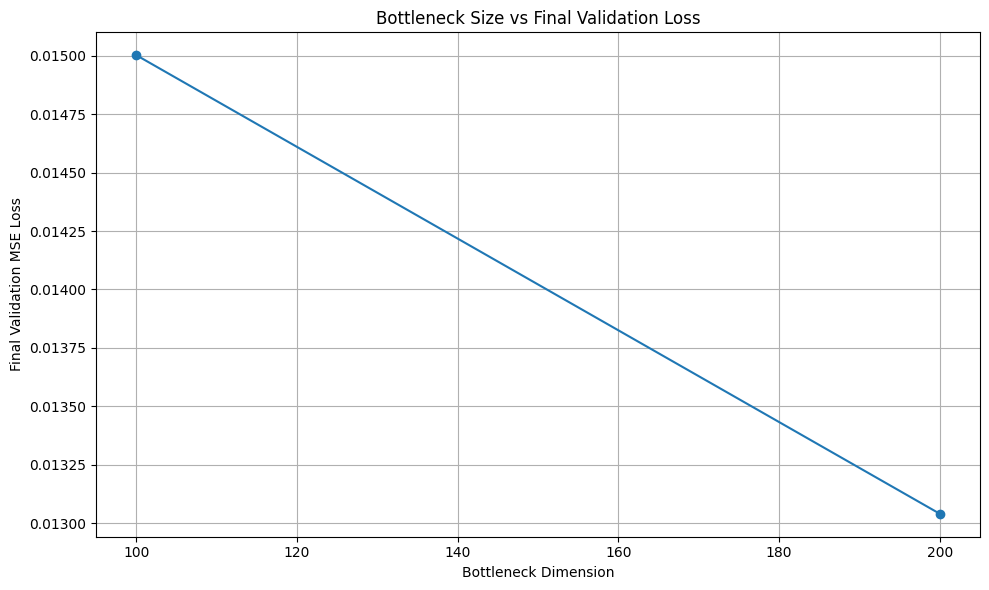

Saved bottleneck vs loss graph to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\bottleneck_vs_loss.png


In [9]:
input_dim = train_images.shape[1]

# List of bottleneck sizes to test
bottleneck_candidates = [100, 200,] #Training on CPU takes too long for larger sizes
bottleneck_results = {}

# Train Autoencoders with different bottlenecks
for bottleneck_dim in bottleneck_candidates:
    print(f"Training Autoencoder with bottleneck_dim = {bottleneck_dim}")

    autoencoder = build_autoencoder(input_dim, bottleneck_dim)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    history = autoencoder.fit(
        train_images, train_images,
        epochs=50,
        batch_size=256,
        validation_data=(val_images, val_images),
        callbacks=[early_stopping],
        verbose=1
    )

    # Get final validation loss
    final_val_loss = history.history['val_loss'][-1]
    bottleneck_results[bottleneck_dim] = final_val_loss
    
# Plot bottleneck size vs final validation loss
plot_bottleneck_vs_loss(
    bottleneck_results,
    save_path=config.EDA_DIR / 'bottleneck_vs_loss.png'
)

#### Optimize Bottleneck Size

In this step, we train multiple autoEncoders with different bottleneck sizes to determine the most effective dimensionality for compressing image data. The bottleneck layer acts as a constraint that forces the network to learn a compressed latent representation of the input. Choosing the right bottleneck size is important — too small and the model loses critical information, too large and we risk keeping noise or irrelevant features.

For each candidate bottleneck size, we:
- Build a new autoEncoder architecture with the specified bottleneck dimension.
- Train the model using the training set and validate on a held-out validation set.
- Apply early stopping via the `EarlyStopping` callback to prevent overfitting. If the validation loss does not improve for 3 consecutive epochs (`patience=3`), training is halted early and the best weights are restored [7].
- Record the final validation loss for each bottleneck size to compare performance.

We use a `for` loop to automate this process over several bottleneck candidates. The result is a mapping of bottleneck dimension to validation loss, which we will visualize and use to select the best compression size. This selected size will be used to train the final autoEncoder in the next step.

The 'Bottleneck Size vs. Final Validation Loss' graph shows the relationship between bottleneck dimension and final validation MSE loss. As expected, increasing the bottleneck size from 100 to 200 results in a noticeable decrease in validation loss. This indicates that a larger bottleneck dimension allows the autoEncoder to retain more meaningful information from the original image, leading to better reconstruction performance.

However, while higher dimensions typically yield lower loss, they also increase feature complexity and computation. For downstream use, such as feeding compressed features into classical models like Random Forest or XGBoost, the best bottleneck is chosen not just for loss performance but also with model efficiency in mind.

In our case, bottleneck size 200 provided the lowest validation loss and was selected as the optimal dimension for further modeling.


###### [7] [Early Stopping to Prevent Overfitting](https://medium.com/@piyushkashyap045/)

Best bottleneck dimension selected: 200
Saved optimization results JSON to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\bottleneck_optimization_results.json
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 440ms/step - loss: 0.0291 - val_loss: 0.0249
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - loss: 0.0223 - val_loss: 0.0192
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - loss: 0.0193 - val_loss: 0.0182
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 402ms/step - loss: 0.0184 - val_loss: 0.0176
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 393ms/step - loss: 0.0175 - val_loss: 0.0166
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 392ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/ste

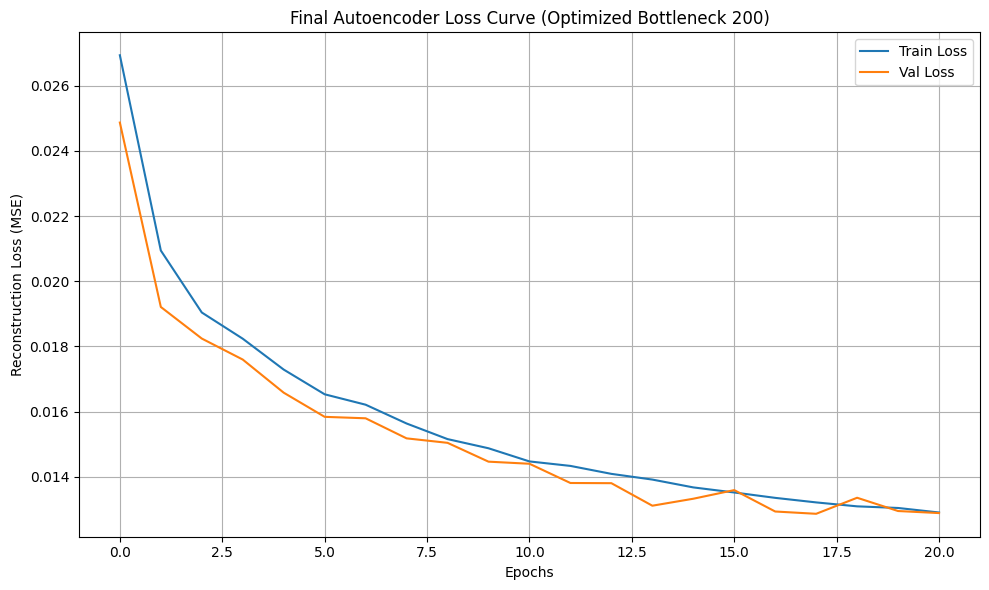

Saved final optimized loss curve to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\optimized_autoencoder_loss_curve.png
Saved final optimized loss curve to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\optimized_autoencoder_loss_curve.png


In [10]:
#Choose best bottleneck dimension based on validation loss
best_bottleneck_dim = min(bottleneck_results, key=bottleneck_results.get)
print(f"Best bottleneck dimension selected: {best_bottleneck_dim}")

# Save bottleneck optimization results to JSON

optimization_results = {
    "all_bottlenecks": bottleneck_results,
    "best_bottleneck_dim": best_bottleneck_dim,
    "best_val_loss": bottleneck_results[best_bottleneck_dim]
}

with open(config.EDA_DIR / 'bottleneck_optimization_results.json', 'w') as f:
    json.dump(optimization_results, f, indent=4)

print(f"Saved optimization results JSON to {config.EDA_DIR / 'bottleneck_optimization_results.json'}")

# Retrain final autoencoder with best bottleneck

autoencoder = build_autoencoder(input_dim, best_bottleneck_dim)

history = autoencoder.fit(
    train_images, train_images,
    epochs=50,
    batch_size=256,
    validation_data=(val_images, val_images),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)],
    verbose=1
)

# Save final optimized loss curve

plot_final_autoencoder_loss(
    history,
    best_bottleneck_dim,
    save_path=config.EDA_DIR / 'optimized_autoencoder_loss_curve.png'
)

print(f"Saved final optimized loss curve to {config.EDA_DIR / 'optimized_autoencoder_loss_curve.png'}")


#### AutoEncoder Training with Optimal Bottleneck

After evaluating the validation loss across multiple bottleneck sizes, we select the best-performing one using:

`best_bottleneck_dim = min(bottleneck_results, key=bottleneck_results.get)`

Next, we store the results of the entire bottleneck optimization process, including all tested sizes, the best size, and the corresponding validation loss, into a dictionary. This dictionary is saved as a .json file for reproducibility and future reference.

With the optimal bottleneck size identified, we retrain the autoEncoder from scratch using this setting. This ensures that the model learns from the full training data with the chosen bottleneck architecture. We again use the EarlyStopping callback to monitor validation loss and prevent overfitting, halting training early if no improvement is seen over 3 consecutive epochs.

Finally, we visualize the training and validation loss curves using the `plot_final_autoencoder_loss()` function. This curve provides insight into how well the model converged and whether the training was stable. The optimized autoEncoder trained here will be used to generate compressed representations (bottleneck features) for downstream tasks like clustering or classification [8].

###### [8] [Bottleneck Sizes and AutoEncoders](https://medium.com/%40tejpal.abhyuday/every-thing-about-autoencoders-efad99fdb8ba)

In [11]:
# Compress all images using final trained model
bottleneck_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
compressed_features = bottleneck_model.predict(X_flat, batch_size=256)

print(f"Compressed features shape: {compressed_features.shape}")

# Save bottleneck feature names for interpretability
bottleneck_dim = compressed_features.shape[1]
feature_names = [f"bottleneck_{i}" for i in range(bottleneck_dim)]

# Load feature names from file
with open(config.OUTPUTS_DIR / "feature_names.json", "w") as f:
    json.dump(feature_names, f)
print(f"Saved bottleneck feature names to {config.OUTPUTS_DIR / 'feature_names.json'}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Compressed features shape: (20638, 200)
Saved bottleneck feature names to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\feature_names.json


#### Generate and Save Bottleneck Features

With the final autoencoder trained using the optimal bottleneck size, we now use it to generate compressed representations for all input images. Specifically, we create a new Keras `Model` that maps the original input to the output of the bottleneck layer. This model essentially acts as an encoder, producing compact feature vectors that represent the essential information in each image.

We then run all flattened and normalized images through this model using `predict()`, resulting in a 2D NumPy array of shape `(num_samples, bottleneck_dim)`, where each row corresponds to a single image's compressed feature vector.

To support interpretability and future use of these features (e.g., in a Random Forest or XGBoost model), we generate names for each bottleneck feature in the form `bottleneck_0`, `bottleneck_1`, ..., and save this list to a JSON file. This ensures that when we load these features later, we retain column names, making the downstream analysis easier to trace.


Shape after t-SNE reduction: (20638, 2)


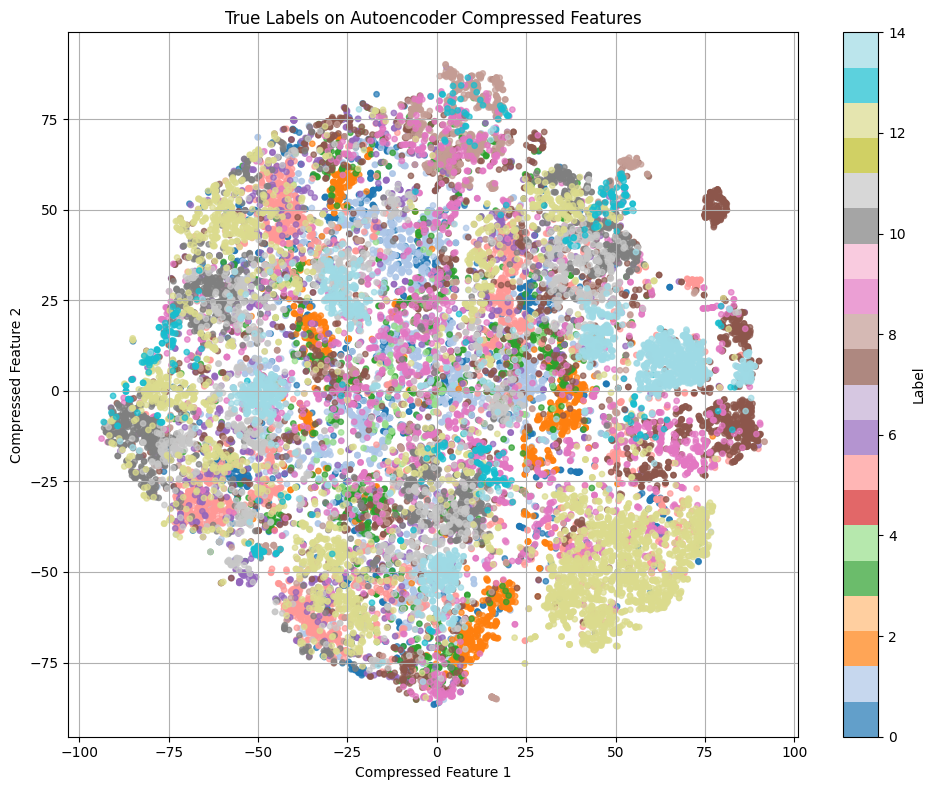

Cluster assignments shape: (20638,)


In [12]:
# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(compressed_features)

print(f"Shape after t-SNE reduction: {features_2d.shape}")

# Encode true labels numerically
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = np.array([label_to_int[label] for label in labels])

# Plot compressed feature space colored by true labels
plot_compressed_scatter(
    features_2d,
    numeric_labels,
    title='True Labels on Autoencoder Compressed Features',
    save_path=config.EDA_DIR / 'true_labels_autoencoder_scatter.png'
)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(compressed_features)
print(f"Cluster assignments shape: {clusters.shape}")

# Plot compressed feature space colored by KMeans clusters
plot_compressed_scatter(
    features_2d,
    clusters,
    title='KMeans Clustering on Autoencoder Compressed Features',
    save_path=config.EDA_DIR / 'kmeans_autoencoder_scatter.png'
)

#### Visualize Compressed Feature Space with t-SNE and KMeans

After generating the compressed bottleneck features using the final autoEncoder, we explore the structure of this latent space using t-distributed Stochastic Neighbor Embedding (t-SNE) and KMeans clustering.

t-SNE is a non-linear dimensionality reduction technique that maps high-dimensional data into 2D space in a way that preserves local structure. This is ideal for visualizing how well the autoEncoder has separated different classes in the compressed space. Since the original bottleneck features are still high-dimensional (e.g., 200D), reducing them to 2D lets us visualize them meaningfully [9].

We first encode the true class labels numerically so that each point can be color-coded by its actual class. We then use `plot_compressed_scatter()` to visualize the 2D projection colored by true labels.

Next, we apply KMeans clustering to the same bottleneck features to see whether the latent space naturally groups the data in meaningful ways, without using the true labels. KMeans assigns each point to one of 15 clusters (matching the number of classes), and we plot this as a second t-SNE visualization, colored by cluster assignment.

These visualizations let us qualitatively evaluate how well the autoEncoder has organized the data, and whether its compressed representations preserve class structure that could help downstream models like classifiers.

#### True Labels on AutoEncoder Compressed Features

In the first t-SNE plot, each point is colored based on its true class label. While there is some overlap across categories, several distinct clusters and dense regions appear, suggesting the autoEncoder has captured meaningful structure. This means that even without explicit supervision, the encoder has learned features that reflect the semantic separation between disease types and healthy leaves.

#### KMeans Clustering on AutoEncoder Compressed Features

In the second plot, the same t-SNE embedding is colored using the cluster assignments from KMeans. Although the clustering is not a perfect match to the true labels, many KMeans clusters align well with the natural groupings observed in the true-label plot. This confirms that the compressed space contains unsupervised structure that KMeans can exploit—an encouraging result that shows the autoEncoder has produced a well-organized latent representation [10][11].*

###### [10] [Clustering Data with K-Means and Visualizing with t-SNE](https://medium.com/%40RobuRishabh/clustering-text-data-with-k-means-and-visualizing-with-t-sne-9bc1fe7d8fed)
###### [11] [EDA with AutoEncoders](https://medium.com/%40girishajmera/autoencoders-tsne-exploratory-data-analysis-on-unlabeled-image-dataset-3bdf499dbad3)

###### **\*** **Note:** All exploratory data analysis outputs, including t-SNE visualizations and clustering plots, are available in `/outputs/EDA`.

In [13]:
# Normalize images
images_normalized = images / 255.0  # Normalize pixel values to [0, 1]

# Combine images and labels into a single dataset for stratified splitting
data = list(zip(images_normalized, labels))

# Split the dataset into train, validation, and test sets with stratification
train_data, temp_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=labels
)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, random_state=42, stratify=[label for _, label in temp_data]
)

# Debugging: Check split sizes
print(f"Train size: {len(train_data)}, Temp size: {len(temp_data)}")
print(f"Validation size: {len(val_data)}, Test size: {len(test_data)}")

# Unzip the data back into images and labels
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Convert back to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

# Debugging: Check label distributions
print(f"Train labels distribution: {collections.Counter(y_train)}")
print(f"Validation labels distribution: {collections.Counter(y_val)}")
print(f"Test labels distribution: {collections.Counter(y_test)}")

Train size: 16510, Temp size: 4128
Validation size: 2064, Test size: 2064
Train labels distribution: Counter({np.int64(12): 2566, np.int64(5): 1701, np.int64(7): 1527, np.int64(9): 1417, np.int64(10): 1341, np.int64(14): 1273, np.int64(1): 1182, np.int64(11): 1123, np.int64(2): 800, np.int64(6): 800, np.int64(3): 800, np.int64(0): 798, np.int64(8): 762, np.int64(13): 298, np.int64(4): 122})
Validation labels distribution: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 168, np.int64(14): 159, np.int64(1): 148, np.int64(11): 140, np.int64(3): 100, np.int64(2): 100, np.int64(6): 100, np.int64(0): 99, np.int64(8): 95, np.int64(13): 38, np.int64(4): 15})
Test labels distribution: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 167, np.int64(14): 159, np.int64(1): 148, np.int64(11): 141, np.int64(6): 100, np.int64(3): 100, np.int64(0): 100, np.int64(2): 100, np.int64(8): 95, np.int64(13): 37, np.

#### Normalize Images and Create Stratified Train/Val/Test Splits for CNN

We begin by normalizing the pixel values of all images by dividing them by 255.0, which scales the original values from the range [0, 255] to [0, 1]. This step is essential for deep learning models like CNNs, as it ensures that input data is on a consistent scale. Neural networks are sensitive to input magnitude—without normalization, large pixel values can lead to unstable gradients and poor convergence during training. Normalization improves numerical stability and allows the optimizer to converge faster and more reliably.

After normalization, we pair each image with its corresponding label and perform a stratified split of the dataset into training, validation, and test sets. Stratified sampling ensures that each split maintains the same class distribution as the original dataset. This is especially important in datasets with class imbalance, as it prevents overrepresentation or underrepresentation of certain classes in the validation or test set, which could skew performance metrics and lead to misleading model evaluations.

The result is three balanced and representative datasets that will be used throughout model training and evaluation.



In [14]:
# Save CNN splits
cnn_split_dir = Path(config.OUTPUTS_DIR) / "splits_cnn"

if not cnn_split_dir.exists() or not all(
    is_split_complete(cnn_split_dir / split_name) for split_name in ["train", "val", "test"]
):  # Check if all splits are complete
    print("CNN splits are incomplete or missing. Regenerating...")
    shutil.rmtree(cnn_split_dir, ignore_errors=True)  # Clear the directory if it exists
    cnn_split_dir.mkdir(parents=True, exist_ok=True)

    print(f"Saving training data to: {cnn_split_dir / 'train'}")
    save_cnn_split(cnn_split_dir, X_train, y_train, "train")

    print(f"Saving validation data to: {cnn_split_dir / 'val'}")
    save_cnn_split(cnn_split_dir, X_val, y_val, "val")

    print(f"Saving test data to: {cnn_split_dir / 'test'}")
    save_cnn_split(cnn_split_dir, X_test, y_test, "test")

    print("CNN splits saved in outputs folder.")
else:
    print("CNN splits already exist and are complete. Skipping save.")

CNN splits already exist and are complete. Skipping save.


#### Save Image-Based Splits for CNN

After creating stratified train, validation, and test splits using the normalized image data, we save them to disk using a custom utility function. These splits are written to structured subfolders (`train/`, `val/`, `test/`) inside the `outputs/splits_cnn/` directory.

Saving the splits ensures that the same data is consistently used during CNN training and evaluation across runs, which is important for reproducibility and comparison. Each subfolder contains the images and labels associated with that particular split, and they are formatted to work seamlessly with `ImageDataGenerator.flow_from_directory()` during model training.

If the folder already exists and contains all three complete splits, the saving step is skipped to avoid unnecessary reprocessing.

In [23]:
# Save RF Splits
rf_split_dir = Path(config.OUTPUTS_DIR) / "splits_rf"
if not rf_split_dir.exists() or not any(rf_split_dir.iterdir()):  # Check if directory exists or is empty
    rf_split_dir.mkdir(parents=True, exist_ok=True)

    # Use compressed features instead of flattening images
    compressed_features_train, compressed_features_temp, y_train, y_temp = train_test_split(
        compressed_features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    compressed_features_val, compressed_features_test, y_val, y_test = train_test_split(
        compressed_features_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
        # Scale the compressed features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(compressed_features_train)  # Fit scaler on training compressed features
    X_val_scaled = scaler.transform(compressed_features_val)          # Transform validation compressed features
    X_test_scaled = scaler.transform(compressed_features_test)        # Transform test compressed features

    # Save RF splits
    np.save(rf_split_dir / "X_train.npy", X_train_scaled)
    np.save(rf_split_dir / "X_val.npy", X_val_scaled)
    np.save(rf_split_dir / "X_test.npy", X_test_scaled)
    np.save(rf_split_dir / "y_train.npy", y_train)
    np.save(rf_split_dir / "y_val.npy", y_val)
    np.save(rf_split_dir / "y_test.npy", y_test)

    print("RF splits saved in outputs folder (compressed features scaled).")
else:
    print("RF splits already exist and are not empty. Skipping save.")

RF splits already exist and are not empty. Skipping save.


#### Create Stratified Splits for Random Forest Using Compressed Features

In this step, we generate stratified train, validation, and test splits using the compressed bottleneck features obtained from our trained autoEncoder. Instead of working with raw image data, we use the output of the bottleneck layer, which represents a lower-dimensional, information-rich embedding of each image.

These compressed features serve as a compact representation of the original data, capturing the most important patterns and spatial relationships necessary for classification. By using them as input to traditional machine learning models like Random Forest, we reduce computational complexity and training time while retaining the key visual signals learned by the autoEncoder.

Just like in the CNN preprocessing step, we apply stratified sampling here to maintain class distribution consistency across all three splits. This ensures fair evaluation and balanced representation, even when using these abstracted representations of the images.


#### Scale and Save RF Feature Splits

After creating stratified train/validation/test splits using the compressed bottleneck features, we perform feature scaling using `StandardScaler`. This step is critical when using models like Random Forest, XGBoost, or other traditional ML algorithms that are sensitive to the magnitude of input values—especially when feature ranges vary.

The bottleneck features learned by the autoEncoder may have very different ranges depending on the activation patterns across neurons. While Random Forest isn’t as sensitive to feature scaling as models like SVMs or KNN, scaling still improves consistency, interpretability, and compatibility with downstream models and evaluation techniques. It also ensures that all features contribute equally during decision-making in ensemble models and avoids biases introduced by uneven scaling.

We use `StandardScaler()` to standardize the features by removing the mean and scaling to unit variance, based only on the training data. This is important: we fit the scaler only on the training set (`fit_transform`), and then apply the same transformation to the validation and test sets (`transform`) to avoid data leakage and maintain fair evaluation conditions.*

Once scaled, the compressed and balanced datasets are saved to disk in `.npy` format under the `outputs/splits_rf/` directory. This allows us to reuse these exact datasets for multiple model experiments without recomputing or risking inconsistencies between runs. The saved files include:
- `X_train.npy`, `X_val.npy`, `X_test.npy`: scaled compressed features
- `y_train.npy`, `y_val.npy`, `y_test.npy`: corresponding labels for each split

This process ensures that our Random Forest pipeline starts with clean, compact, scaled, and reproducible data—all derived from the autoEncoder's learned latent space.

###### **\*** **Note:** Flattening is not applied to Random Forest data. Instead of using raw pixel values, the model is trained on compressed bottleneck features produced by the autoencoder, which are already in a flattened and dimensionally reduced form.



In [24]:
# Define the output directory for transformed training images
cnn_train_dir_transformed = Path(config.OUTPUTS_DIR) / "splits_cnn_transformed" / "train"

# Define the transformation pipeline for training data
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Transform and Save Training Data
if not is_folder_complete(cnn_train_dir_transformed, y_train):
    print("Transformed CNN training data is incomplete or missing. Regenerating...")
    shutil.rmtree(cnn_train_dir_transformed, ignore_errors=True)  # Clear only the transformed training directory
    apply_transformations_and_save(X_train, y_train, cnn_train_dir_transformed, train_transform)  # Augment training set
    print("Transformed CNN training data saved.")
else:
    print("Transformed CNN training data already exists and is complete. Skipping transformation.")

Transformed CNN training data already exists and is complete. Skipping transformation.


##### Apply and Save Transformations to CNN Training Data

To improve generalization, we apply data augmentation techniques to the CNN training set. These include random rotation, color jittering, resizing, and horizontal flipping, which simulate natural variability in leaf appearance (e.g., lighting, angle, position) [12][13].

The transformations are applied using a `torchvision.transforms.Compose()` pipeline. Once transformed, the training images are saved to disk under `outputs/splits_cnn_transformed/train`.

If the folder already exists and is complete, we skip this step to avoid redundant processing. Otherwise, the original training set is cleared and regenerated with the augmentations applied.


###### [12] [Fine Tuning Transforms](https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde)
###### [13] [Transforming and Augmenting Images](https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde)

In [25]:
# Debugging: Check validation and test directories
cnn_val_dir = Path(config.OUTPUTS_DIR) / "splits_cnn" / "val"
cnn_test_dir = Path(config.OUTPUTS_DIR) / "splits_cnn" / "test"

if not cnn_val_dir.exists() or not any(cnn_val_dir.iterdir()):
    print(f"Validation directory is missing or empty: {cnn_val_dir}")
else:
    print(f"Validation directory exists and contains files: {cnn_val_dir}")

if not cnn_test_dir.exists() or not any(cnn_test_dir.iterdir()):
    print(f"Test directory is missing or empty: {cnn_test_dir}")
else:
    print(f"Test directory exists and contains files: {cnn_test_dir}")

Validation directory exists and contains files: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\val
Test directory exists and contains files: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\test


#### Check Validation and Test Set Directory Integrity

Before training the CNN, we ensure the validation and test sets are present and complete. These sets are not augmented, so they should exist unmodified under `outputs/splits_cnn/val` and `outputs/splits_cnn/test`. This check ensures the evaluation pipeline is intact and won't fail due to missing or incomplete folders.


In [26]:
# Load labels
y_train = np.load(config.RF_SPLITS_DIR / 'y_train.npy')
y_val = np.load(config.RF_SPLITS_DIR / 'y_val.npy')
y_test = np.load(config.RF_SPLITS_DIR / 'y_test.npy')

# Count classes
print("Random Forest - Train Class Counts:", collections.Counter(y_train))
print("Random Forest - Val Class Counts:", collections.Counter(y_val))
print("Random Forest - Test Class Counts:", collections.Counter(y_test))


# Load class names from JSON
with open(config.OUTPUTS_DIR / "class_names.json") as f:
    categories = json.load(f)

# CNN Transformed splits (train)
cnn_train_counts = count_images_per_class(config.CNN_SPLITS_DIR / 'train', categories)

# CNN Validation/Test split (untouched)
cnn_val_counts = count_images_per_class(config.CNN_VAL_DIR, categories)
cnn_test_counts = count_images_per_class(config.CNN_TEST_DIR, categories)

# Print counts
print("\nCNN - Train Class Counts:", cnn_train_counts)
print("CNN - Val Class Counts:", cnn_val_counts)
print("CNN - Test Class Counts:", cnn_test_counts)

Random Forest - Train Class Counts: Counter({np.int64(12): 2566, np.int64(5): 1701, np.int64(7): 1527, np.int64(9): 1417, np.int64(10): 1341, np.int64(14): 1273, np.int64(1): 1182, np.int64(11): 1123, np.int64(2): 800, np.int64(6): 800, np.int64(3): 800, np.int64(0): 798, np.int64(8): 762, np.int64(13): 298, np.int64(4): 122})
Random Forest - Val Class Counts: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 168, np.int64(14): 159, np.int64(1): 148, np.int64(11): 140, np.int64(3): 100, np.int64(2): 100, np.int64(6): 100, np.int64(0): 99, np.int64(8): 95, np.int64(13): 38, np.int64(4): 15})
Random Forest - Test Class Counts: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 167, np.int64(14): 159, np.int64(1): 148, np.int64(11): 141, np.int64(6): 100, np.int64(3): 100, np.int64(0): 100, np.int64(2): 100, np.int64(8): 95, np.int64(13): 37, np.int64(4): 15})

CNN - Train Class Counts: {'Pepper__be

#### Load and Compare Class Distributions for RF and CNN Splits

To validate our preprocessing pipeline and ensure class balance, we load the saved labels and count the number of samples per class across all splits. For the Random Forest pipeline, we load labels from the `.npy` files saved earlier. For the CNN pipeline, we count images directly from the saved directories (`train`, `val`, `test`), using class folder names to determine label counts.

This comparison ensures that our stratified splitting preserved class balance and that no classes were dropped, misaligned, or overrepresented during the transformation and saving processes.


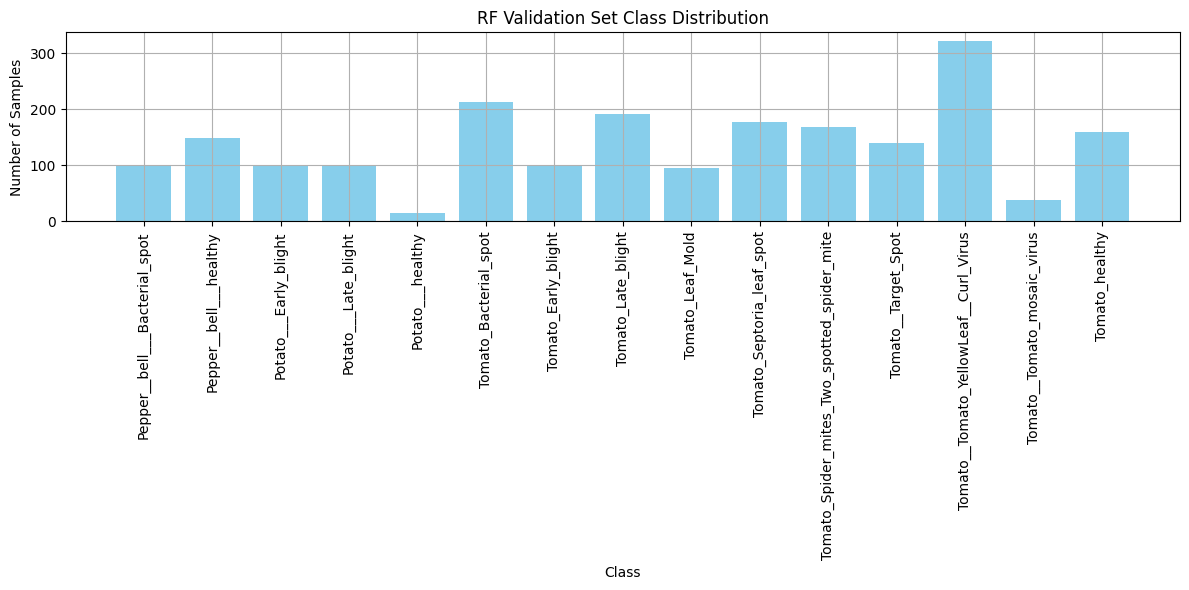

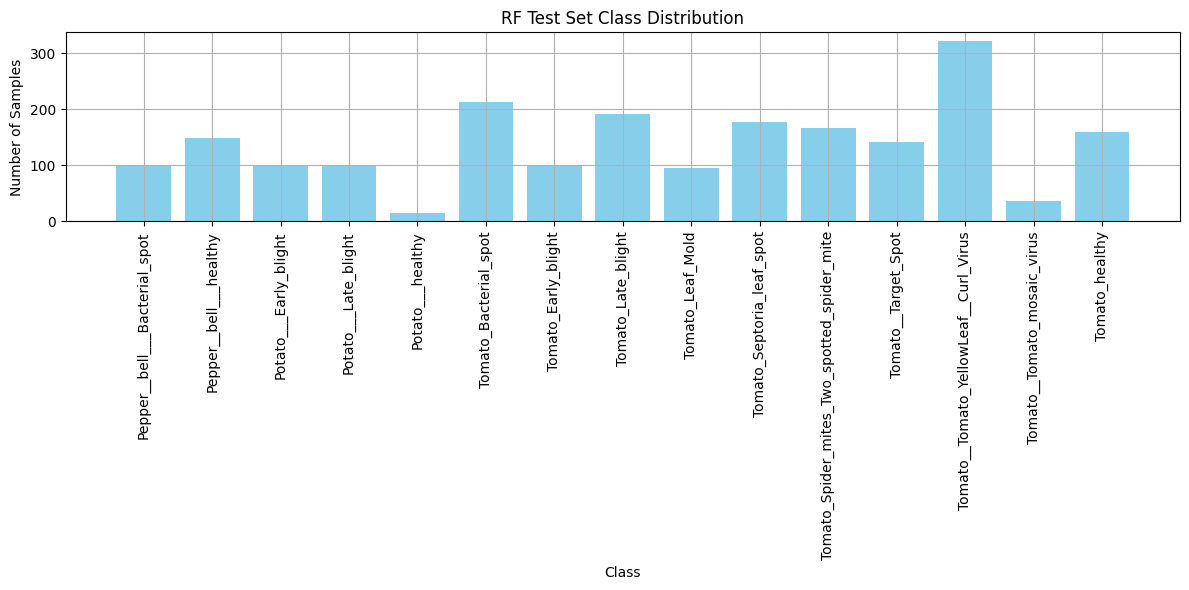

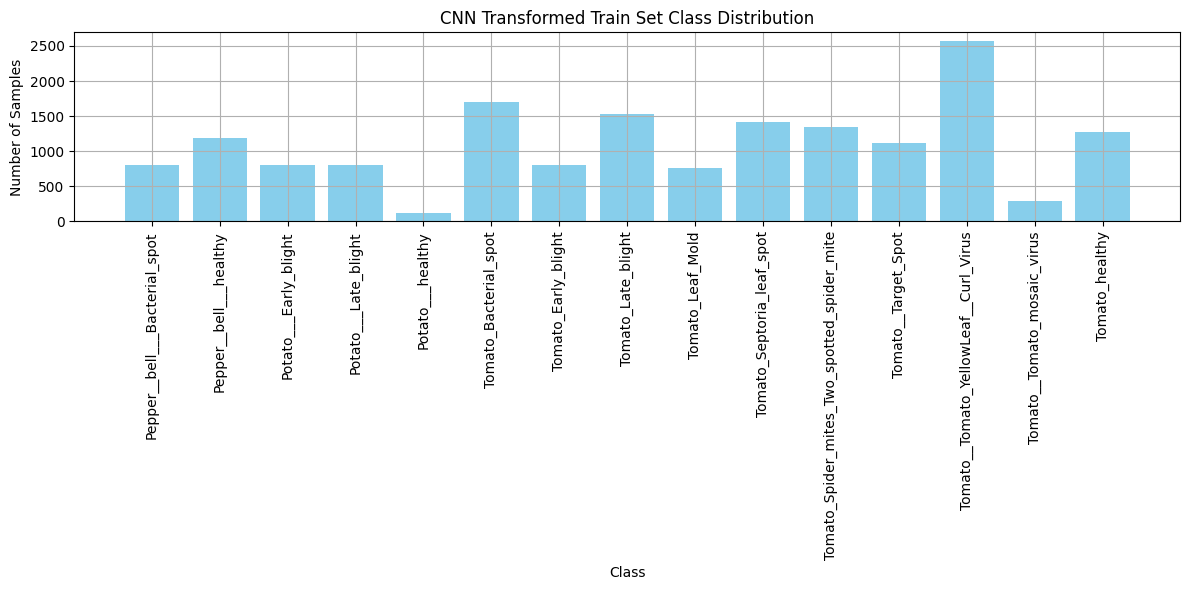

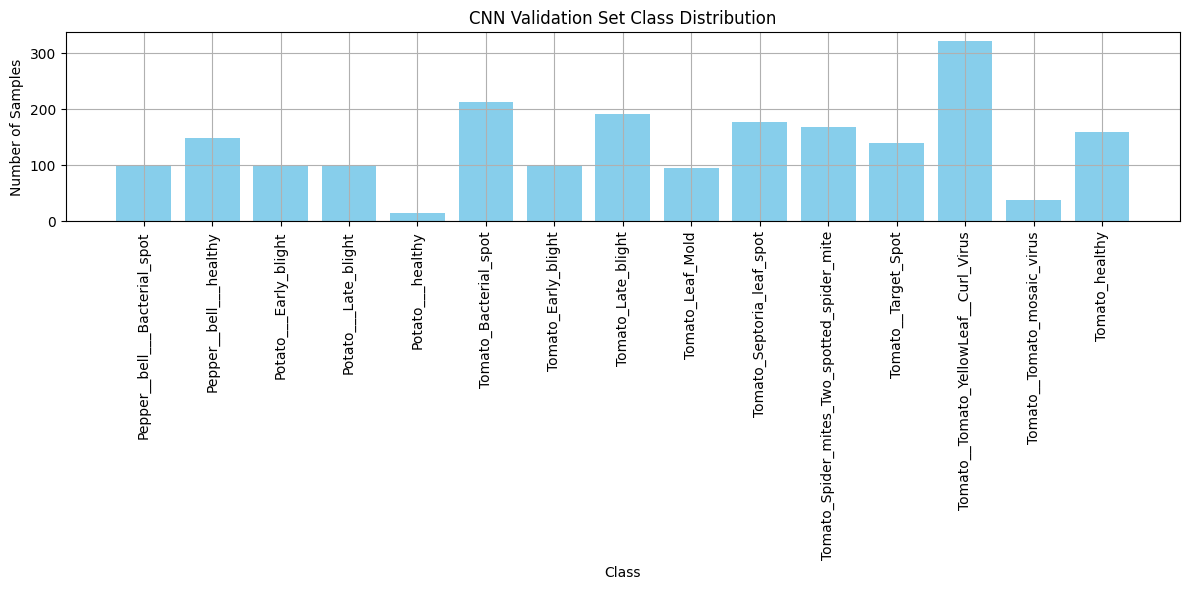

In [27]:
# Plotting RF class distributions
plot_rf_class_distribution(y_train, "RF Train Set Class Distribution", categories, save_path=config.EDA_DIR / "rf_train_class_distribution.png")
plot_rf_class_distribution(y_val, "RF Validation Set Class Distribution", categories, save_path=config.EDA_DIR / "rf_val_class_distribution.png")
plot_rf_class_distribution(y_test, "RF Test Set Class Distribution", categories, save_path=config.EDA_DIR / "rf_test_class_distribution.png")


# Plotting class distributions for CNN splits
plot_cnn_class_distribution(cnn_train_counts, 'CNN Transformed Train Set Class Distribution', categories, save_path=config.EDA_DIR / "cnn_train_class_distribution.png")
plot_cnn_class_distribution(cnn_val_counts, 'CNN Validation Set Class Distribution', categories, save_path=config.EDA_DIR / "cnn_val_class_distribution.png")
plot_cnn_class_distribution(cnn_test_counts, 'CNN Test Set Class Distribution', categories, save_path=config.EDA_DIR / "cnn_test_class_distribution.png")

#### Visualize Class Distributions for Random Forest and CNN Splits

After confirming class counts, we generate bar plots to visually inspect the distribution across all training, validation, and test sets. This allows us to quickly detect any imbalance or preprocessing errors. We visualize both pipelines side by side: the Random Forest pipeline (using bottleneck features) and the CNN pipeline (using raw/transformed image folders).


In [28]:
# Check if resampling needs to be applied
if not (is_valid_file(config.resampled_X_train_path) and is_valid_file(config.resampled_y_train_path)):
    # Load the RF dataset splits
    X_train = np.load(config.original_X_train_path)
    y_train = np.load(config.original_y_train_path)

    # Print class distribution before SMOTETomek
    print_class_distribution_with_names(Counter(y_train), categories, "Class distribution before SMOTETomek:")

    # Apply SMOTETomek to balance the dataset
    smote_tomek = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

    # Print class distribution after SMOTETomek
    print_class_distribution_with_names(Counter(y_train_resampled), categories, "\nClass distribution after SMOTETomek:")

    # Save the resampled data (no scaling, as it's already scaled)
    np.save(config.resampled_X_train_path, X_train_resampled)
    np.save(config.resampled_y_train_path, y_train_resampled)

    # Save metadata with more detailed info 
    metadata = {
        "original_class_distribution": dict(Counter(map(int, y_train))),
        "resampled_class_distribution": dict(Counter(map(int, y_train_resampled))),
        "resampling_method": "SMOTETomek",
        "random_state": 42,
        "original_data_shape": X_train.shape,
        "resampled_data_shape": X_train_resampled.shape 
    }
    with open(config.metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    print("\nResampled training data has been saved, along with metadata.")

else:
    print("Resampled data already exists and is valid. Skipping SMOTETomek.")

Resampled data already exists and is valid. Skipping SMOTETomek.


#### Apply SMOTETomek to Balance the Random Forest Training Set

In this section, we address potential class imbalance in the Random Forest training data using a resampling technique called SMOTETomek. But first, we check whether the resampled dataset already exists. If both the feature and label `.npy` files (`resampled_X_train.npy` and `resampled_y_train.npy`) are found and valid, we skip the resampling step entirely to avoid redundant computation.

If the resampled data is missing or incomplete, we proceed by loading the original (scaled) training data and applying SMOTETomek, a widely used technique for dealing with imbalanced datasets.


#### What is SMOTETomek?

SMOTETomek is a two-step resampling method that combines:
- SMOTE (Synthetic Minority Over-sampling Technique): This method generates synthetic samples for minority classes by interpolating between existing samples. It helps balance the class distribution without simply duplicating existing rows.
- Tomek Links: These are pairs of examples from different classes that are each other's nearest neighbors. Tomek Link removal acts as a cleaning step—eliminating ambiguous samples near the class boundaries, which often cause confusion for classifiers.

By combining both, SMOTETomek not only balances the class distribution but also improves the separation between classes, making the data cleaner and more learnable for traditional machine learning models like Random Forest and XGBoost [14].

#### Resampling Execution and Output Structure

1. Load the original training set from `.npy` files.
2. Print the class distribution before resampling to visualize any imbalance.
3. Apply SMOTETomek to generate a balanced and cleaned version of the dataset.
4. Print the new class distribution to confirm the balancing effect.
5. Save the resampled data to disk:
   - Features → `resampled_X_train.npy`
   - Labels → `resampled_y_train.npy`
6. Save a metadata JSON file that records:
   - Original vs. resampled class distributions
   - Data shapes
   - Resampling method and random seed
   - File paths used

This data is saved in the configured output directory (e.g., `outputs/splits_rf/`), and it will be used for training the final Random Forest and/or XGBoost models with balanced inputs. This ensures fairer learning, especially for underrepresented disease classes that might otherwise be ignored by the model.

###### [14] [SmoteTOMEK](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)

In [29]:
file_names = [
    "X_train.npy",
    "X_train_resampled.npy",
    "X_val.npy",
    "X_test.npy",
    "y_train.npy",
    "y_train_resampled.npy",
    "y_val.npy",
    "y_test.npy"
]

# Loop through each file and print the dtype
print("Confirmation of data types and shapes:\n")

rf_split_dir = config.RF_SPLITS_DIR
for file_name in file_names:
    file_path = rf_split_dir / file_name
    data = np.load(file_path)
    print(f"{file_name}: dtype = {data.dtype}, shape = {data.shape}")

Confirmation of data types and shapes:

X_train.npy: dtype = float32, shape = (16510, 200)
X_train_resampled.npy: dtype = float32, shape = (38320, 200)
X_val.npy: dtype = float32, shape = (2064, 200)
X_test.npy: dtype = float32, shape = (2064, 200)
y_train.npy: dtype = int64, shape = (16510,)
y_train_resampled.npy: dtype = int64, shape = (38320,)
y_val.npy: dtype = int64, shape = (2064,)
y_test.npy: dtype = int64, shape = (2064,)


#### Confirm Data Types and Shapes of Saved RF Splits

As a final check before training, we verify that all saved `.npy` files used in the Random Forest pipeline have the correct data types and shapes. This includes both the original and resampled training sets, as well as the validation and test splits.

Ensuring consistent `dtype` (typically `float32` or `float64` for features, and `int` for labels) is essential before training, especially when working across different models and libraries. Mismatches in shape or type can lead to subtle bugs, runtime errors, or degraded model performance.

We loop through all relevant files in the `outputs/splits_rf/` directory and print a summary of their type and dimensions to confirm everything is correctly prepared for model input.


In [30]:
# RF training and validation

# Set the path to RF splits directory
config.RF_SPLITS_DIR = Path.cwd().parent / "outputs" / "splits_rf"

# Load training data
X_train = np.load(config.RF_SPLITS_DIR / "X_train_resampled.npy")
y_train = np.load(config.RF_SPLITS_DIR / "y_train_resampled.npy")

# Load validation data
X_val = np.load(config.RF_SPLITS_DIR / "X_val.npy")
y_val = np.load(config.RF_SPLITS_DIR / "y_val.npy")

print("Data loaded successfully.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Data loaded successfully.
X_train shape: (38320, 200), y_train shape: (38320,)
X_val shape: (2064, 200), y_val shape: (2064,)


#### Load Training and Validation Data for Random Forest Model

Our next step is to train our Random Forest model. We begin by loading the preprocessed, scaled, and resampled training and validation data saved earlier. This ensures our Random Forest model uses clean, balanced input with consistent shapes.


In [31]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, 8, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt'],
    'class_weight': ['balanced'],
    'bootstrap': [True]  
}

# Initialize base Random Forest 
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Setup StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=stratified_cv,
    scoring='accuracy',         
    verbose=1,                  # Basic output during fitting
    n_jobs=-1                   # Use all CPUs
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best results
print("\nBest Hyperparameters:")
print(grid_search.best_params_)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 252 candidates, totalling 1260 fits

Best Hyperparameters:
{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.9031


#### Random Forest Hyperparameter Tuning via GridSearchCV

To find the best-performing Random Forest model, we perform a grid search over a range of hyperparameters using `GridSearchCV`. This process trains and evaluates models using different hyperparameter combinations to identify the configuration that performs best on unseen data.

##### What is GridSearchCV?

`GridSearchCV` is a utility in scikit-learn that:
1. Takes a predefined set of hyperparameters (`param_grid`)
2. Trains a model for **every possible combination** of those hyperparameters
3. Evaluates each model using cross-validation
4. Returns the model with the best average performance according to a chosen scoring metric

This systematic process removes guesswork and ensures that our final model selection is backed by performance across multiple folds, reducing the risk of overfitting to a particular split of the training data.

##### What’s in Our Hyperparameter Grid and Why?

Our `param_grid` includes a broad but practical set of hyperparameters that control the structure and behavior of each Random Forest model:

- `n_estimators`: `[50, 100, 200]`  
  Controls the number of trees in the forest. More trees generally improve performance but increase computation time.

- `max_depth`: `[2, 4, 6, 8, 10, 15, 20]`  
  Limits the depth of each tree. Shallow trees prevent overfitting but may underfit complex patterns; deeper trees offer more flexibility.

- `min_samples_split`: `[2, 5, 10, 15]`  
  The minimum number of samples required to split an internal node. Larger values increase regularization.

- `min_samples_leaf`: `[1, 2, 5]`  
  The minimum number of samples that must be present at a leaf node. Helps control tree complexity and encourages generalization.

- `max_features`: `['sqrt']`  
  Controls how many features the model considers when splitting a node. `'sqrt'` is a standard setting for classification tasks.

- `class_weight`: `['balanced']`  
  Automatically adjusts weights inversely proportional to class frequencies. This is crucial for our imbalanced, multi-class dataset, ensuring minority classes are not ignored during training.

- `bootstrap`: `[True]`  
  Enables bootstrap sampling, which is standard for bagged ensemble models like Random Forest.

Together, this grid enables `GridSearchCV` to explore a rich space of trade-offs between bias, variance, and training stability.

##### Why Use Accuracy as the Scoring Metric?

We selected accuracy as the scoring metric because it provides a straightforward measure of how often the model's predictions match the true class labels. Although alternative metrics like F1-score or balanced accuracy are more robust to imbalance, we use stratified sampling (see below) and class weighting to account for class skew.

In our use case:
- We care about overall prediction correctness across all classes
- We mitigate class imbalance using `'class_weight': 'balanced'` and SMOTETomek
- Therefore, accuracy remains a reasonable and interpretable baseline metric for optimization

Additional metrics (e.g., F1, ROC-AUC) are computed later for deeper evaluation.

#### Why We Use StratifiedKFold (Not Regular KFold)

Our dataset contains 15+ classes, many of which have significantly fewer samples than others. Using regular `KFold` would risk splitting minority classes unevenly across folds, leading to:
- Poor class representation during training
- Misleading validation scores due to missing classes in certain folds

Instead, we use `StratifiedKFold`, which:
- Ensures each fold maintains the same class distribution as the full dataset
- Provides a fair and consistent evaluation of model performance on both majority and minority classes

This is critical for a multi-class problem with imbalance, and allows `GridSearchCV` to make informed, balanced comparisons between model configurations [15].

#### What Happens After Grid Search?

Once the grid search completes:
- We extract the best-performing parameters using `grid_search.best_params_`
- The corresponding model (`grid_search.best_estimator_`) is saved for future use in validation, testing, or deployment

This trained model represents the most optimized configuration from the entire search space based on our chosen scoring strategy.

#### Grid Search Results


This model achieved a cross-validation accuracy of ~90.31%, indicating strong generalization during 5-fold Stratified CV.

Key takeaways:
- A deeper tree (`max_depth = 20`) and more estimators (`n_estimators = 200`) improved learning capacity.
- Using `'balanced'` class weights and StratifiedKFold helped mitigate class imbalance.
- Low `min_samples_leaf` and `min_samples_split` allowed trees to grow deeply, which performed well on the resampled training data.

This configuration is now used for final validation and testing.

###### [15] [StratifiedKFold](https://medium.com/%40juanc.olamendy/a-comprehensive-guide-to-stratified-k-fold-cross-validation-for-unbalanced-data-014691060f17)


In [ ]:
# Get the best estimator for rf
best_rf_model = grid_search.best_estimator_

# Save the best RF model for later testing
model_save_path = config.RF_RESULTS_DIR / "best_rf_model.joblib"
joblib.dump(best_rf_model, model_save_path)
print(f"Best RF model saved to {model_save_path}")

# Evaluate on validation set
y_val_pred = best_rf_model.predict(X_val)

# Evaluate accuracy and classification report on validation set
print("\nValidation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC Score (macro averaged) on validation set
try:
    roc_auc = roc_auc_score(y_val, best_rf_model.predict_proba(X_val), multi_class='ovr', average='macro')
    print(f"Macro ROC-AUC Score: {roc_auc:.4f}")
except AttributeError:
    print("ROC-AUC could not be calculated (model might not have predict_proba).")

Best RF model saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\best_rf_model.joblib

Validation Set Performance:
Accuracy: 0.6846
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.46      0.46        99
           1       0.62      0.76      0.69       148
           2       0.67      0.87      0.76       100
           3       0.50      0.52      0.51       100
           4       0.25      0.07      0.11        15
           5       0.74      0.72      0.73       213
           6       0.48      0.35      0.40       100
           7       0.75      0.55      0.64       191
           8       0.78      0.77      0.77        95
           9       0.57      0.46      0.51       177
          10       0.74      0.74      0.74       168
          11       0.64      0.66      0.65       140
          12       0.80      0.87      0.83       321
          13       0.49      0.63      0.55        38
      

#### Save Best RF Model and Evaluate on Validation Data

We retrieve the best model found during cross-validation, save it to disk, and evaluate its performance on the unseen validation set using accuracy, classification report, and macro-averaged ROC-AUC.

#### Validation Set Performance

After selecting the best hyperparameters from GridSearchCV, we evaluated the model on a held-out validation set. The overall accuracy was ~68.46%, and detailed class-wise performance is shown below:

- High-performing classes included Class 2 (`f1 = 0.76`) and Class 5 (`f1 = 0.73`), both of which had strong precision and recall.
- Mid-tier performance was observed in Classes 1, 7, 8, and 9, with F1-scores ranging from 0.64 to 0.77.
- Low performance was seen in Class 4 (`f1 = 0.11`), which had very few examples in the validation set (support = 15). This highlights continued difficulty with rare classes, even after using class weighting and SMOTETomek.
- Class 6 also underperformed (`f1 = 0.40`), likely due to overlapping visual features with other categories.

While the model generalizes well to most classes, there is still room to improve performance on underrepresented or visually similar categories. Ensemble stacking or feature refinement may help.


In [33]:
# Prepare validation results dictionary
validation_results = {
    'accuracy': accuracy_score(y_val, y_val_pred),
    'classification_report': classification_report(y_val, y_val_pred, output_dict=True),  # Use output_dict=True for clean JSON
}

# Try adding ROC-AUC to validation results
try:
    validation_results['roc_auc_macro'] = roc_auc_score(y_val, best_rf_model.predict_proba(X_val), multi_class='ovr', average='macro')
except AttributeError:
    validation_results['roc_auc_macro'] = None

# Save validation results as JSON
with open(config.RF_RESULTS_DIR / 'validation_results.json', 'w') as f:
    json.dump(validation_results, f, indent=4)

print(f"Validation results saved to {config.RF_RESULTS_DIR / 'validation_results.json'}")

Validation results saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\validation_results.json


#### Save Evaluation Results to JSON

We format the key validation metrics—including accuracy, classification report, and ROC-AUC (if available)—into a dictionary and save them as a `.json` file for reproducibility and downstream reporting.

The file is saved to:

`outputs/results_rf/validation_results.json`

This ensures the evaluation results can be reused or referenced later without rerunning the model.


Confusion matrix saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\confusion_matrix.png


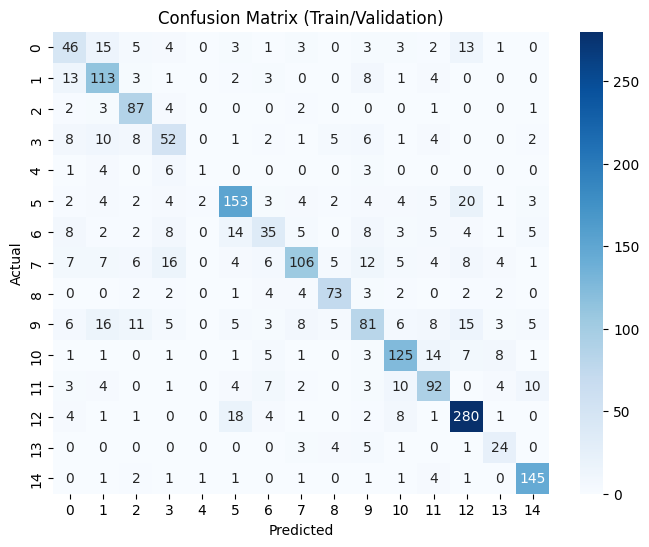

Heatmap saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\n_estimators_vs_max_depth_heatmap.png


In [34]:
# Generate and save confusion matrix
confusion_matrix_path = config.RF_RESULTS_DIR / 'confusion_matrix.png'
plot_rf_confusion_matrix_train(y_val, y_val_pred, confusion_matrix_path)

# Extract and pivot grid search results
scores_matrix = extract_and_pivot_gridsearch_train(grid_search)

# Plot and save heatmap
heatmap_path = config.RF_RESULTS_DIR / "n_estimators_vs_max_depth_heatmap.png"
plot_rf_heatmap_train(scores_matrix, heatmap_path)

#### Visualize Confusion Matrix and Grid Search Heatmap

To gain deeper insight into our model's behavior, we visualize two key outputs:

#### Confusion Matrix (Validation Set)

The confusion matrix summarizes how well the Random Forest model classifies each class in the validation set. Diagonal cells represent correct predictions, while off-diagonal values show misclassifications.

From the plot:
- The model performs very well on class 12 (`280` correct), indicating strong detection of that category.
- Classes like 5, 10, and 1 also show strong diagonal dominance, with 153, 125, and 113 correct predictions respectively.
- However, confusion exists between certain visually similar classes, such as:
  - Class 0 and Class 1 (13 misclassified as 1)
  - Class 6 showing a spread of misclassifications across many categories
  - Class 4 having no strong prediction pattern, which aligns with its poor F1-score

This visualization reinforces our earlier observation: the model does well on common and visually distinct classes but struggles on rare or overlapping ones.

#### Hyperparameter Grid Search Heatmap

This heatmap shows the mean accuracy scores from GridSearchCV as a function of `n_estimators` and `max_depth`.

Key observations:
- Accuracy consistently improves as both `n_estimators` and `max_depth` increase.
- The best combination (`n_estimators = 200`, `max_depth = 20`) achieved 90.31% cross-validation accuracy, confirming that a deeper, more complex forest improves learning capacity for this task.
- Shallower models (e.g., `max_depth = 2–6`) underperform significantly, with accuracies below 60%, suggesting underfitting.

This heatmap clearly shows that model accuracy improves with deeper trees and more estimators. It justifies not only the hyperparameters chosen for our best model but also reinforces the broader insight that Random Forest performance can be significantly improved through thoughtful hyperparameter tuning. The highest-performing zone in the bottom-right of the grid confirms that deeper, more expressive models (e.g., `max_depth = 20`, `n_estimators = 200`) are better suited for capturing the complexity of this task.




In [35]:
# Sort by score
sorted_indices = np.argsort(grid_search.cv_results_['mean_test_score'])[::-1]  # descending order
sorted_scores = np.array(grid_search.cv_results_['mean_test_score'])[sorted_indices]
sorted_params = np.array(grid_search.cv_results_['params'])[sorted_indices]

# Plot top 20 models
top20_plot_path = config.RF_RESULTS_DIR / 'top20_models.png'
plot_top20_gridsearch_models(sorted_scores, top20_plot_path, top_k=20)

# Prepare metadata to save
# Usage example in your RFtrain.py:
save_rf_gridsearch_metadata_train(
    grid_search=grid_search,
    param_grid=param_grid,
    confusion_matrix_path=confusion_matrix_path,
    top20_plot_path=top20_plot_path,
    heatmap_path=heatmap_path,
    save_dir=config.RF_RESULTS_DIR
)

Top 20 models plot saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\top20_models.png



GridSearch metadata saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\gridsearch_metadata.json


#### Plot Top 20 Models and Save GridSearch Metadata

We rank and visualize the top 20 performing hyperparameter combinations from the GridSearchCV results based on mean cross-validation accuracy. This plot provides a quick way to assess how much performance varies among the best models and helps confirm that our selected configuration is truly optimal.

As shown in the chart, the best model achieves just over 90% CV accuracy, with a gradual performance decline among subsequent candidates. This suggests our hyperparameter space was well-chosen, as several configurations cluster near the top.

Finally, we serialize and save all GridSearch metadata, including parameter scores, confusion matrix path, and visualizations. This ensures full traceability of the tuning process and makes future inspection or replication straightforward.*

###### **\*** **Note:** All outputs and visualizations from the CNN training/validation process can be found in `/outputs/training_results/RF`.


#### Model Improvements

Although the current Random Forest model performs well, there are clear opportunities for further enhancement.

First, the hyperparameter search space can be expanded. This includes testing higher values for `n_estimators`, exploring deeper or more constrained tree structures (`max_depth`, `min_samples_leaf`, etc.), and evaluating additional `max_features` strategies such as `'log2'` or fixed float values. A finer grid or randomized search could also help pinpoint optimal configurations more precisely.

To address the persistent challenges of class imbalance, future work could experiment with:
- Alternative resampling methods
- Cost-sensitive learning with customized `class_weight` values
- Hybrid ensembles that combine over- and under-sampling within the model itself

It may also be valuable to explore other validation techniques which could yield more stable performance estimates.

Finally, while Random Forest provides interpretability and robust performance, integrating more advanced models like XGBoost or model stacking may unlock additional gains, particularly for borderline or low-support classes.

In short, the current model establishes a strong baseline, and there’s clear potential for further improvement through expanded tuning, smarter sampling, and complementary model strategies.


In [36]:
# Load data
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    config.CNN_SPLITS_DIR / "train",
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    config.CNN_VAL_DIR,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=False 
)

Found 16510 images belonging to 15 classes.
Found 2064 images belonging to 15 classes.


#### Load Training and Validation Data for CNN Model

We begin by loading the preprocessed image splits using `ImageDataGenerator`, a Keras utility that allows us to efficiently load and preprocess image data in batches. It streams images from disk during training, which is memory-efficient, and optionally applies real-time data augmentation.

In this setup:
- The training generator applies data augmentation (if specified) and yields batches of images and labels during training.
- The validation generator loads images without augmentation and uses `shuffle=False` to preserve label order, which is necessary for later evaluation steps like Grad-CAM and classification reports.

We use a `batch_size` of 64 as a balance between memory usage and training speed — large enough for efficient CPU/GPU utilization but small enough to avoid out-of-memory errors on typical setups [16].

###### [16] [Image Data Preparation](https://iqbalpa.medium.com/easily-image-data-preparation-with-imagedatagenerator-in-tensorflow-5fd75fb32bc2)


In [37]:
# Build improved CNN model
input_shape = (128, 128, 3)
num_classes = len(train_generator.class_indices)
model = build_improved_cnn_model(input_shape, num_classes)
model.summary()

# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint_path = config.CNN_RESULTS_DIR / "best_model.keras"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,559 (517.81 KB)

 Trainable params: 132,111 (516.06 KB)

 Non-trainable params: 448 (1.75 KB)

#### Model Architecture and Training Strategy

We use a custom-designed convolutional neural network (`build_improved_cnn_model`) that balances expressive capacity with regularization to reduce overfitting. The architecture consists of:

- Three convolutional blocks with increasing filter sizes: `Conv2D(32) → Conv2D(64) → Conv2D(128)`.
- Each block includes ReLU activation, MaxPooling2D to reduce spatial dimensions, and BatchNormalization to stabilize learning [17].
- All `Conv2D` layers include L2 regularization (`l2_value=0.0001`) to discourage large weights.
- A GlobalAveragePooling2D layer replaces flattening to reduce parameters and overfitting risk [18].
- A fully connected `Dense(256)` layer with ReLU and Dropout(0.5) provides strong regularization before the output [19].
- The output layer uses `softmax` activation for multi-class classification [20].

This architecture is designed to be efficient and modular, making it well-suited for training on datasets like PlantVillage while remaining scalable for larger datasets. It incorporates modern best practices such as batch normalization, dropout, and L2 regularization, and can be easily extended by adding more convolutional layers or increasing filter sizes as needed.

#### EarlyStopping and ReduceLROnPlateau

To further stabilize training and prevent overfitting, we use two key callbacks:

- EarlyStopping monitors validation loss and stops training if it doesn't improve for 8 consecutive epochs. It also restores the best weights from the lowest validation loss.
- ReduceLROnPlateau dynamically lowers the learning rate when validation loss plateaus (patience = 3), allowing the model to continue refining weights at a smaller step size.

Together, these callbacks help ensure that the model doesn't overtrain while still allowing it to escape plateaus and converge more effectively [21].

###### [17] [Batch Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)
###### [18] [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)
###### [19] [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
###### [20] [tf.keras.activations.softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax)
###### [21] [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/)

In [38]:
print("Train class distribution:", np.bincount(train_generator.classes))
print("Val class distribution:", np.bincount(val_generator.classes))
print("Class indices:", train_generator.class_indices)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, lr_schedule, model_checkpoint]
)

Train class distribution: [ 798 1182 1341 1123 2566  298 1273  800  800  122 1701  800 1527  762
 1417]
Val class distribution: [ 99 148 168 140 321  38 159 100 100  15 213 100 191  95 177]
Class indices: {'class_0': 0, 'class_1': 1, 'class_10': 2, 'class_11': 3, 'class_12': 4, 'class_13': 5, 'class_14': 6, 'class_2': 7, 'class_3': 8, 'class_4': 9, 'class_5': 10, 'class_6': 11, 'class_7': 12, 'class_8': 13, 'class_9': 14}
Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3842 - loss: 2.1132
Epoch 1: val_accuracy improved from -inf to 0.41037, saving model to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\cnn\best_model.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 67s 253ms/step - accuracy: 0.3845 - loss: 2.1124 - val_accuracy: 0.4104 - val_loss: 2.1688 - learning_rate: 0.0010
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5884 - loss: 1.6229
Epoch 2: val_accuracy improved from 0.41037 to 0.60029, saving model to C:\Users\petev\OneDrive\De

#### Training the CNN Model

We fit the CNN model using the training generator and validate against the held-out validation generator. Training uses the defined callbacks to monitor progress and save the best model based on validation accuracy.

#### Results

Training stopped early at ~epoch 48 due to lack of improvement in validation loss. The model automatically restored the weights from epoch ~40, which had the lowest recorded validation loss, as configured by the `EarlyStopping` callback.

Starting evaluation and visualization...
Results will be saved to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\cnn
Plotting training curves...
Training curves saved.


Generating predictions...
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
Predictions completed.
Generating confusion matrix...
Confusion matrix saved.


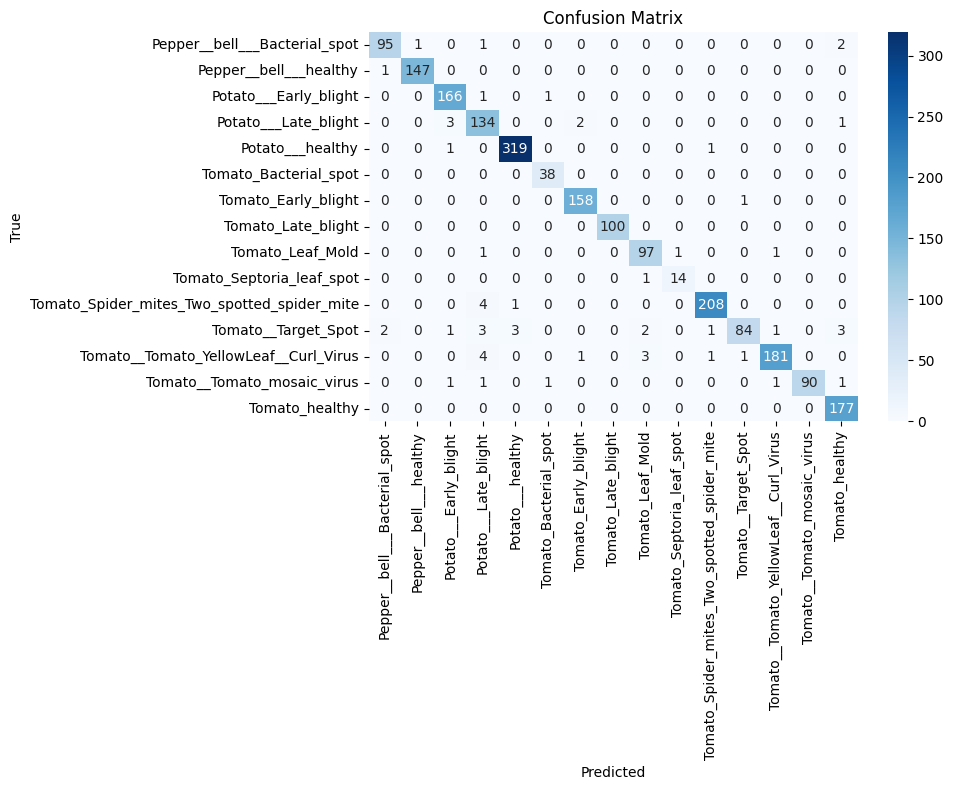

Generating prediction visualizations...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction visualizations saved.


Generating Grad-CAM visualizations...
Using Conv2D layer for Grad-CAM: conv2d_2
[INFO] Grad-CAM visualizations saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\cnn\gradcam
Generating Grad-CAM visualizations...
Using Conv2D layer for Grad-CAM: conv2d_2
[INFO] Grad-CAM visualizations saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\cnn\gradcam


In [39]:
# Convert Sequential to Functional for Grad-CAM
if hasattr(model, "to_json") and model.__class__.__name__ == "Sequential":
    model_config = model.get_config()
    input_shape = model.input_shape[1:]
    inputs = Input(shape=input_shape, name="gradcam_input")
    x = inputs
    for layer_conf in model_config['layers'][1:]:
        layer = layers.deserialize(layer_conf)
        x = layer(x)
    functional_model = Model(inputs, x)
    functional_model.set_weights(model.get_weights())
else:
    functional_model = model

# Load class names
with open(config.OUTPUTS_DIR / "class_names.json") as f:
    class_names = json.load(f)

# Plot predictions, confusion matrix
evaluate_and_visualize_model(
    model,
    functional_model,
    val_generator,
    history,
    class_names=class_names
)

# Display Grad-CAM overlays
overlays = generate_gradcam_visualizations(
    functional_model,
    val_generator,
    config.CNN_RESULTS_DIR,
    return_overlays=True
)

plt.figure(figsize=(15, 6))
for i, overlay in enumerate(overlays):
    plt.subplot(2, 5, i+1)
    plt.imshow(overlay)
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Post-Training Evaluation and Grad-CAM Compatibility

Before evaluating and visualizing the trained CNN model, we first ensure it is compatible with Grad-CAM visualizations. Grad-CAM requires a Functional model, but if the model was built using the Keras Sequential API, we convert it to Functional by manually reconstructing the architecture using the saved configuration. This allows Grad-CAM to access intermediate layers for generating class activation heatmaps [22][23].

We then load the class names from `class_names.json` and pass everything into the `evaluate_and_visualize_model()` utility. This function automatically generates key diagnostic plots for post-training evaluation.

#### Training Curves: Accuracy and Loss Over Epochs

The training curves graph show the model's accuracy and loss over time. Key observations:

- Training accuracy steadily increases to nearly 100%, while validation accuracy stabilizes around ~94–95%, indicating good generalization.
- Validation loss fluctuates more than training loss, which is expected due to batch-level variability and early stopping behavior.
- Training was halted at ~epoch 48, and the model weights from ~epoch 40 (the best validation performance) were restored.

This confirms that early stopping effectively captured the optimal performance point without overfitting.

#### Confusion Matrix

The confusion matrix provides a detailed breakdown of prediction accuracy for each class. Strong diagonal values—especially for `Tomato_healthy`, `Potato_healthy`, and `Tomato_YellowLeaf_Curl_Virus`—indicate excellent performance on those categories.

A few off-diagonal errors appear in visually similar classes like `Pepper_bell___Bacterial_spot` and `Potato__Late_blight`, which could be due to overlapping visual features or noise in sample quality.

#### Prediction Visualizations with Confidence Scores

The final grid shows individual prediction examples from the validation set. Each example includes:
- The input image
- The model’s predicted class and confidence score
- A bar chart showing class probability distribution

These examples help verify model behavior. For instance:
- The majority of correct predictions (green labels) show very high confidence.
- Misclassifications (e.g., red label: `Potato__Late_blight` predicted instead of `Pepper_bell___Bacterial_spot`) often show lower confidence or class confusion with nearby visual distributions.

This visualization confirms the model is making informed predictions and provides insight into failure cases, which could guide future data augmentation or model improvements.

#### Grad-CAM Overlays: Visualizing CNN Attention

Grad-CAM (Gradient-weighted Class Activation Mapping) is a visualization technique that reveals which regions of an input image contribute most to the CNN's prediction for a given class. It works by backpropagating the gradients of the target class into the final convolutional layer and highlighting the areas with the strongest influence [24].

#### Why This Is Useful

Grad-CAM provides interpretability for what would otherwise be a black-box model:
- It helps us verify that the CNN is attending to relevant regions, such as lesions, discoloration, or texture changes on the leaf surface.
- It helps diagnose failure cases, such as when the model focuses on background noise or edges rather than the leaf area.
- It builds trust in the model by providing a human-interpretable explanation of its decisions.

#### Overlay Interpretation

The visualization displays Grad-CAM overlays for 10 validation samples. The highlighted (brighter) regions indicate where the model focused when predicting each image's class.

Across these examples, we observe:
- Consistent attention centered on leaf veins, edges, or disease-affected regions
- Heatmaps are tightly focused, suggesting the model is not distracted by irrelevant image regions
- Some variance in activation spread, which could reflect the heterogeneity of disease presentation across samples

Overall, the Grad-CAM results confirm that the model's decisions are grounded in biologically plausible regions, supporting the model's reliability in this plant disease classification task.

###### [22] [Model Config Serialization](https://keras.io/api/models/model_saving_apis/model_config_serialization)
###### [23] [Grad-CAM: Visualization Activation](https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning)
###### [24] [Grad-CAM Class Activation and Visualization](https://keras.io/examples/vision/grad_cam)

In [40]:
# Predict on validation set without TTA and save classification report
val_generator.reset()
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = val_generator.classes

non_tta_report = classification_report(
    y_true_labels, y_pred_labels,
    target_names=class_names,
    output_dict=True
)

# Non-TTA Classification Report
non_tta_report_path = config.CNN_RESULTS_DIR / "non_tta_classification_report.json"
with open(non_tta_report_path, 'w') as f:
    json.dump(non_tta_report, f, indent=4)
non_tta_df = pd.DataFrame(non_tta_report).transpose()

# TTA Predictions and Report
print("\nRunning TTA on validation set...")
y_pred_tta, y_true_tta = tta_predict(model, val_generator, num_classes, tta_steps=5)
y_pred_tta_labels = np.argmax(y_pred_tta, axis=1)
y_true_tta_labels = np.argmax(y_true_tta, axis=1)
tta_report = classification_report(y_true_tta_labels, y_pred_tta_labels, target_names=class_names, output_dict=True)
tta_df = pd.DataFrame(tta_report).transpose()

# Display Both Reports Side by Side
display(ipd.HTML("<h4>Non-TTA Classification Report</h4>"))
display(non_tta_df)
display(ipd.HTML("<h4>TTA Classification Report</h4>"))
display(tta_df)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Running TTA on validation set...


precision    recall  f1-score  \
Pepper__bell___Bacterial_spot                 0.969388  0.959596  0.964467   
Pepper__bell___healthy                        0.993243  0.993243  0.993243   
Potato___Early_blight                         0.965116  0.988095  0.976471   
Potato___Late_blight                          0.899329  0.957143  0.927336   
Potato___healthy                              0.987616  0.993769  0.990683   
Tomato_Bacterial_spot                         0.950000  1.000000  0.974359   
Tomato_Early_blight                           0.981366  0.993711  0.987500   
Tomato_Late_blight                            1.000000  1.000000  1.000000   
Tomato_Leaf_Mold                              0.941748  0.970000  0.955665   
Tomato_Septoria_leaf_spot                     0.933333  0.933333  0.933333   
Tomato_Spider_mites_Two_spotted_spider_mite   0.985782  0.976526  0.981132   
Tomato__Target_Spot                           0.976744  0.840000  0.903226   
Tomato__Tomato_YellowLeaf__Curl_Virus         0.983696  0.947644  0.965333   
Tomato__Tomato_mosaic_virus                   1.000000  0.947368  0.972973   
Tomato_healthy                                0.961957  1.000000  0.980609   
accuracy                                      0.972868  0.972868  0.972868   
macro avg                                     0.968621  0.966695  0.967089   
weighted avg                                  0.973425  0.972868  0.972700   

                                                 support  
Pepper__bell___Bacterial_spot                  99.000000  
Pepper__bell___healthy                        148.000000  
Potato___Early_blight                         168.000000  
Potato___Late_blight                          140.000000  
Potato___healthy                              321.000000  
Tomato_Bacterial_spot                          38.000000  
Tomato_Early_blight                           159.000000  
Tomato_Late_blight                            100.000000  
Tomato_Leaf_Mold                              100.000000  
Tomato_Septoria_leaf_spot                      15.000000  
Tomato_Spider_mites_Two_spotted_spider_mite   213.000000  
Tomato__Target_Spot                           100.000000  
Tomato__Tomato_YellowLeaf__Curl_Virus         191.000000  
Tomato__Tomato_mosaic_virus                    95.000000  
Tomato_healthy                                177.000000  
accuracy                                        0.972868  
macro avg                                    2064.000000  
weighted avg                                 2064.000000

precision    recall  f1-score  \
Pepper__bell___Bacterial_spot                 0.978947  0.939394  0.958763   
Pepper__bell___healthy                        0.980000  0.993243  0.986577   
Potato___Early_blight                         0.970930  0.994048  0.982353   
Potato___Late_blight                          0.911565  0.957143  0.933798   
Potato___healthy                              0.990625  0.987539  0.989080   
Tomato_Bacterial_spot                         0.926829  1.000000  0.962025   
Tomato_Early_blight                           0.981250  0.987421  0.984326   
Tomato_Late_blight                            1.000000  1.000000  1.000000   
Tomato_Leaf_Mold                              0.969697  0.960000  0.964824   
Tomato_Septoria_leaf_spot                     1.000000  1.000000  1.000000   
Tomato_Spider_mites_Two_spotted_spider_mite   0.976744  0.985915  0.981308   
Tomato__Target_Spot                           0.966292  0.860000  0.910053   
Tomato__Tomato_YellowLeaf__Curl_Virus         0.972973  0.942408  0.957447   
Tomato__Tomato_mosaic_virus                   0.989130  0.957895  0.973262   
Tomato_healthy                                0.961957  1.000000  0.980609   
accuracy                                      0.972868  0.972868  0.972868   
macro avg                                     0.971796  0.971000  0.970962   
weighted avg                                  0.973177  0.972868  0.972705   

                                                 support  
Pepper__bell___Bacterial_spot                  99.000000  
Pepper__bell___healthy                        148.000000  
Potato___Early_blight                         168.000000  
Potato___Late_blight                          140.000000  
Potato___healthy                              321.000000  
Tomato_Bacterial_spot                          38.000000  
Tomato_Early_blight                           159.000000  
Tomato_Late_blight                            100.000000  
Tomato_Leaf_Mold                              100.000000  
Tomato_Septoria_leaf_spot                      15.000000  
Tomato_Spider_mites_Two_spotted_spider_mite   213.000000  
Tomato__Target_Spot                           100.000000  
Tomato__Tomato_YellowLeaf__Curl_Virus         191.000000  
Tomato__Tomato_mosaic_virus                    95.000000  
Tomato_healthy                                177.000000  
accuracy                                        0.972868  
macro avg                                    2064.000000  
weighted avg                                 2064.000000

#### Test-Time Augmentation (TTA) Evaluation

Test-Time Augmentation (TTA) is a technique used to improve model performance and prediction stability at inference time. Instead of making predictions on each image as-is, TTA generates multiple augmented versions of the same image (e.g., flipped, rotated, or color-shifted) and averages the model's predictions across those transformations [25][26].

#### Why Use TTA?

We include TTA to:
- Smooth out prediction noise caused by subtle variations in input
- Boost model generalization without retraining
- Improve robustness in real-world deployment, where leaf images may vary in angle, lighting, or texture


#### Performance Comparison (Standard vs. TTA)

As seen in the classification reports:

- The overall accuracy remained identical at 97.29%, showing that the model is already highly confident on most inputs.
- However, class-level precision and recall improved marginally for some difficult categories:
  - `Tomato_Leaf_Mold` improved from an F1-score of ~0.9557 to ~0.9648
  - `Tomato_Target_Spot` improved from ~0.9032 to ~0.9101
  - `Tomato_Tomato_mosaic_virus` also saw an increase in F1-score from ~0.9730 to ~0.9733

In contrast, a few stable classes (like `Tomato_healthy` and `Tomato_Late_blight`) remained perfect or nearly perfect in both setups, showing that TTA did not degrade their results.

#### TTA Conclusion

While TTA did not drastically change the model’s accuracy, it provided slight performance boosts in edge cases and helps smooth out predictions for harder-to-classify or visually noisy samples. It is a valuable step, especially in high-stakes or real-world plant disease diagnosis systems where even small gains in reliability matter.

###### [25] [TTA for Cell Segmentation](https://www.nature.com/articles/s41598-020-61808-3)
###### [26] [Understanding TTA](https://arxiv.org/html/2402.06892v1)

In [41]:
# Save all metrics (TTA and non-TTA)
save_cnn_metrics_to_json(
    output_dir=config.CNN_RESULTS_DIR,
    history=history,
    class_names=class_names,
    y_true=y_true_tta_labels,
    y_pred=y_pred_tta_labels,
    y_pred_probs=y_pred_tta,
    tta_report=tta_report,
    non_tta_report=non_tta_report,
    y_true_non_tta=y_true_labels,
    y_pred_non_tta=y_pred_labels,
    y_pred_probs_non_tta=y_pred_probs
)

# Save model summary, architecture, and weights
save_model_summary_arch_weights(
    model,
    output_path=config.CNN_RESULTS_DIR / "model_summary_arch_weights.json"
)

Saved CNN metrics (TTA and non-TTA) to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\cnn\cnn_tta_vs_non_tta.json


We then save all important outputs including training history, evaluation reports (TTA and non-TTA), prediction probabilities, and full model architecture with weights for reproducibility.*

###### **\*** **Note:** All outputs and visualizations from the CNN training/validation process can be found in `/outputs/training_results/CNN`.

#### Model Improvements
The CNN model performed exceptionally well on our current dataset, indicating that it effectively learned discriminative features for leaf classification. However, to enhance its generalization and scalability in real-world applications, one key improvement would be to retrain the model on masked images. This would help it focus solely on the leaf structure, reducing the influence of background noise — which may vary significantly in practical field conditions. Additionally, we could explore additional data augmentation techniques that simulate real-world variability in lighting, orientation, and background complexity. Incorporating label smoothing or dropout regularization could also improve robustness. Finally, evaluating the model's performance across different environments or acquisition devices would further ensure its reliability in deployment scenarios [27] [28].

###### [27] [Label Smoothing Explained](https://medium.com/%40amit25173/label-smoothing-explained-1b0f13754ae9)
###### [28] [Dropout Regularization](https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/)

In [42]:
# Load test data
X_test = np.load(config.RF_SPLITS_DIR / "X_test.npy")
y_test = np.load(config.RF_SPLITS_DIR / "y_test.npy")

# Load the trained model
model_path = config.RF_RESULTS_DIR / "best_rf_model.joblib"
rf_model = joblib.load(model_path)

#### Load Test Data and Trained RF Model

Now, we move onto evaluating the final Random Forest model on the held-out test set. This step allows us to objectively assess the model's generalization performance on completely unseen data.

First, we load the final test split (`X_test`, `y_test`) and retrieve the best-performing RF model saved during the earlier hyperparameter tuning and validation stage. This ensures consistency between model evaluation and the exact configuration selected during cross-validation.


In [43]:
y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cls_report = classification_report(y_test, y_pred, output_dict=True)

try:
    roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test), multi_class='ovr', average='macro')
except Exception:
    roc_auc = None

# Save results as JSON
test_results = {
    "accuracy": acc,
    "classification_report": cls_report,
    "roc_auc_macro": roc_auc
}
with open(config.RF_TEST_RESULTS_DIR / "test_results.json", "w") as f:
    json.dump(test_results, f, indent=4)

print(f"Test results saved to {config.RF_TEST_RESULTS_DIR / 'test_results.json'}")

Test results saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf\test_results.json


#### Make Predictions

We predict test labels and compute the overall accuracy, detailed classification report, and macro-averaged ROC-AUC score.

#### Save Evaluation Results

After computing the test accuracy, full classification report, and macro-averaged ROC-AUC, we save all metrics to a structured `.json` file. This ensures that the results are:

- Permanently recorded for reproducibility and reporting
- Easily accessible for downstream analysis or comparison with other models
- Formatted in a machine-readable structure that can be parsed later

The file is saved to:

`/outputs/training_results/RF/test_results.json`

This directory contains all key outputs related to the final Random Forest model’s performance on the test set.


In [44]:
feature_importance_path = config.RF_TEST_RESULTS_DIR / "feature_importance.png"
plot_rf_feature_importance_test(rf_model, feature_names, feature_importance_path)

Feature importance plot saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf\feature_importance.png


#### Feature Importance Analysis

After evaluating the model on the test set, we plot the top-ranked features used by the Random Forest to make predictions. These features correspond to individual dimensions of the compressed feature space produced by the autoencoder bottleneck layer (e.g., `bottleneck_119`, `bottleneck_104`, etc.).

The bar chart above displays the top 20 bottleneck features based on their mean decrease in impurity, which is how Random Forest measures importance internally. The most important feature (`bottleneck_119`) has a slightly higher weight than others, but overall, importance values are evenly distributed, indicating that the model does not overly depend on any single feature.

While individual bottleneck dimensions are not directly interpretable, this visualization still provides valuable insight:
- It confirms that the compressed latent space is rich and multidimensional, with no overreliance on a small subset of features.
- It suggests that our autoencoder has successfully preserved diverse patterns relevant to disease classification.

In practice, interpretability could be improved by applying dimensional attribution or analyzing activation patterns in the original image space, but this requires more advanced model inspection tools.


Confusion matrix saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf\confusion_matrix.png


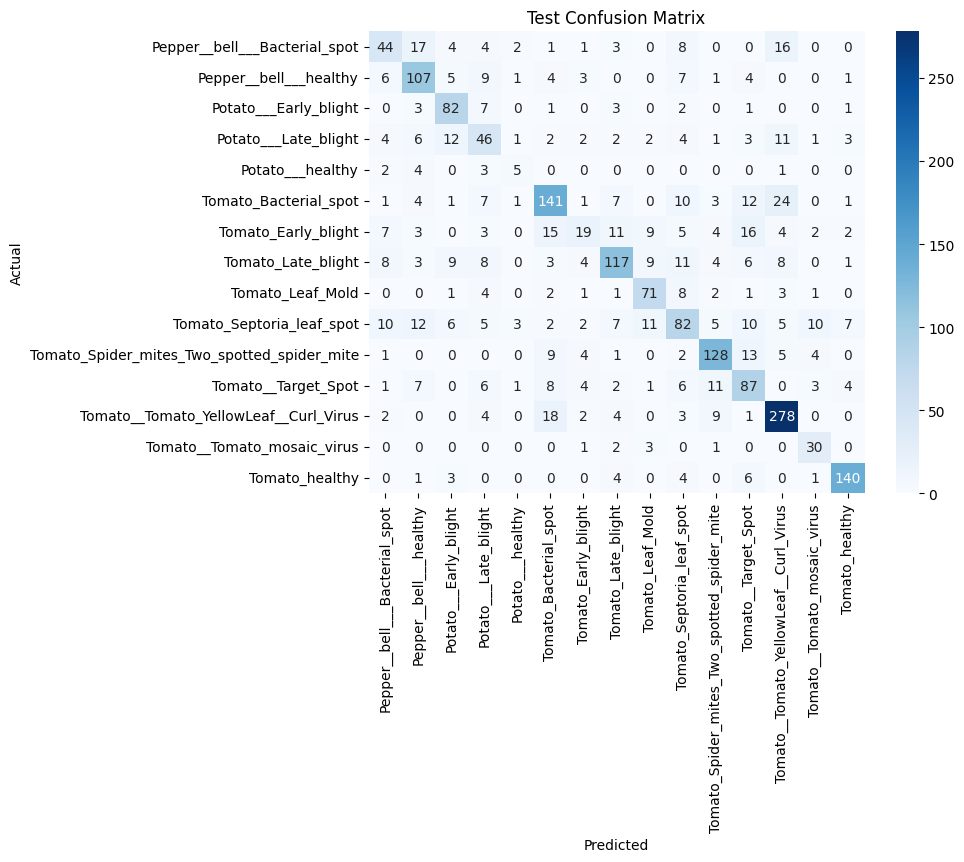

In [45]:
# Confusion matrix
cm_path = config.RF_TEST_RESULTS_DIR / "confusion_matrix.png"
plot_rf_confusion_matrix_test(y_test, y_pred, cm_path, class_names=categories)
plt.show()

#### Confusion Matrix Analysis

The confusion matrix summarizes the final Random Forest model’s classification performance across all 15 plant disease and health categories on the test set.

Diagonal values represent correctly predicted instances, while off-diagonal values indicate misclassifications. As expected, several classes show strong prediction accuracy, including:

- `Tomato_YellowLeaf_Curl_Virus` (~278 correct).
- `Tomato_Bacterial_spot` (~141 correct).
- `Tomato_healthy` (~140 correct).
- `Tomato_Spider_mites_Two_spotted_spider_mite` (~128 correct).

These high-accuracy predictions are reflected by dominant values on the diagonal for these rows.

However, certain categories show noticeable confusion. For instance:

- `Pepper_bell___Bacterial_spot` has frequent misclassifications into `Pepper_bell___healthy` (17) and `Tomato_Bacterial_spot` (16).
- `Tomato_Sepetoria_leaf_spot` is confused with many classes, suggesting it shares visual features with other tomato diseases.
- Both `Potato_Early_blight` and `Potato_Late_blight` show moderate confusion with each other, which is expected due to similar leaf damage patterns.

This matrix provides granular insights into where the model is confident vs. uncertain, and helps identify classes that may benefit from additional training examples, better feature representation, or class-specific tuning.


Probabilities heatmap saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf\probabilities_heatmap.png


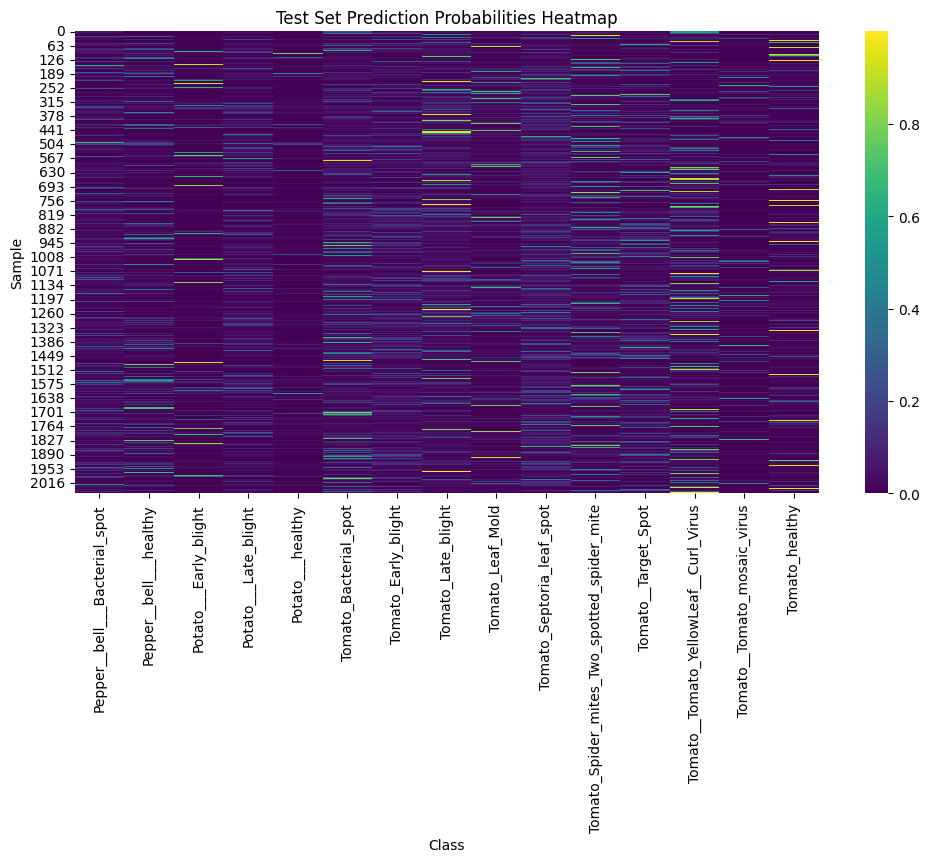

In [46]:
# Heatmap of probabilities
try:
    proba = rf_model.predict_proba(X_test)
    proba_path = config.RF_TEST_RESULTS_DIR / "probabilities_heatmap.png"
    plot_rf_probabilities_heatmap_test(proba, proba_path, class_names=categories)
    plt.show()
except Exception as e:
    print(f"Could not plot probabilities heatmap: {e}")

#### Prediction Probability Heatmap

The heatmap above visualizes the class probabilities output by the Random Forest model for each test sample. Each row corresponds to one prediction (sample), while each column represents a class label. Color intensity reflects the predicted probability — with brighter vertical lines indicating high confidence in a particular class.

In this heatmap, we observe a healthy number of strong confidence predictions, where the model assigns close to 1.0 probability to a single class. These appear as thin, bright stripes scattered vertically. This aligns with the model’s high ROC-AUC score (~0.9416), suggesting that the model’s output probabilities are well-calibrated overall.

However, there are many instances where color intensity is more diffuse — suggesting uncertainty in predictions. These ambiguous predictions typically correspond to misclassifications in the confusion matrix and are most frequent in visually similar classes like the different tomato or potato diseases.

This visualization is helpful for:
- Assessing confidence in the model’s predictions
- Diagnosing potential calibration issues
- Identifying samples that might benefit from further human review or post-processing adjustments

Overall, the heatmap adds a probabilistic layer of interpretability beyond the hard class labels seen in the confusion matrix.


In [47]:
with open(config.RF_TEST_RESULTS_DIR / "test_results.json", "r") as f:
    results = json.load(f)

# Extract weighted average metrics
weighted_avg = results["classification_report"]["weighted avg"]
print("\nWeighted Average Metrics (all classes):")
for metric, value in weighted_avg.items():
    print(f"{metric}: {value:.4f}")

# Extract and print ROC-AUC (macro)
roc_auc = results.get("roc_auc_macro", None)
print(f"\nROC-AUC (macro): {roc_auc:.4f}" if roc_auc is not None else "\nROC-AUC (macro): N/A")


Weighted Average Metrics (all classes):
precision: 0.6593
recall: 0.6672
f1-score: 0.6587
support: 2064.0000

ROC-AUC (macro): 0.9416


#### Print Key Test Metrics

Finally, we extract the saved evaluation results and print the weighted average metrics and ROC-AUC score for a high-level summary.

#### Final Test Performance Summary

The final Random Forest model was evaluated on a test set consisting of 2,064 samples. The key performance metrics are as follows:

- Weighted Precision: ~0.659  
  On average, ~65.9% of predicted class labels were correct across all classes, weighted by class frequency.
  
- Weighted Recall: ~0.667  
  The model correctly identified 66.7% of actual instances, again accounting for class imbalance.
  
- Weighted F1-score: ~0.659  
  This harmonic mean of precision and recall reflects the model’s overall balance between false positives and false negatives.

These values suggest moderate classification performance, indicating that the model performs reasonably well across most classes, though likely struggles with some underrepresented or visually similar categories.

#### ROC-AUC (macro): ~0.9416

The model achieved a macro-averaged ROC-AUC score of 0.9416, indicating strong probabilistic separability between classes. This means that—even when the final predicted class may be incorrect—the model often assigns high probabilities to the correct class, reflecting high confidence and good calibration.

#### Summary

This performance suggests that the model is capable of discriminating well between disease types, but its final classification decisions may benefit from further improvements such as threshold tuning, stacking with another model (e.g., XGBoost), or targeted error analysis on confused class pairs.*

###### **\*** **Note:** All outputs and visualizations from the RF testing process are saved in `/outputs/testing_results/RF`.


In [48]:
# Load test data
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    config.CNN_TEST_DIR,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Load the trained model
model_path = config.CNN_RESULTS_DIR / "best_model.keras"
model = load_model(model_path)

Found 2064 images belonging to 15 classes.


#### Load Test Data and Trained CNN Model

We begin by loading the test dataset using `ImageDataGenerator()`, which standardizes the image input pipeline for inference. Images are loaded from disk in batches of 64 and resized to 128×128 pixels to match the input shape expected by the model. Shuffling is disabled to ensure consistency between predictions and ground-truth labels.


In [49]:
# Predict
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = test_generator.classes

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step


#### Make Predictions

The model predicts class probabilities for each test sample. We then convert these probabilities to final class labels using np.argmax(), and extract the true labels from the test generator.

We compute the overall accuracy, a full classification report (precision, recall, F1-score per class), and the macro-averaged ROC-AUC score using the predicted probability distributions.

In [50]:
# Load class names from JSON
with open(config.OUTPUTS_DIR / "class_names.json") as f:
    class_names = json.load(f)

We then load class names from the `class_names.json` file to ensure our evaluation visuals—such as confusion matrices and prediction explanation grids—use human-readable labels for better interpretability.


In [51]:
# Accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)

# Classification report
cls_report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)

# ROC-AUC (macro)
try:
    roc_auc = roc_auc_score(y_true_labels, y_pred_probs, multi_class='ovr', average='macro')
except Exception:
    roc_auc = None

#### Compute Evaluation Metrics

We compute three key evaluation metrics to assess model performance on the test set. First, we calculate overall accuracy to measure the proportion of correct predictions. Then, we generate a detailed classification report that includes precision, recall, and F1-score for each class. Finally, we attempt to compute the macro-averaged ROC-AUC score to evaluate how well the model separates classes based on predicted probabilities.

In [52]:
# Save results as JSON
test_results = {
    "accuracy": acc,
    "classification_report": cls_report,
    "roc_auc_macro": roc_auc
}

os.makedirs(config.CNN_TEST_RESULTS_DIR, exist_ok=True)
with open(config.CNN_TEST_RESULTS_DIR / "test_results.json", "w") as f:
    json.dump(test_results, f, indent=4)

print(f"Test results saved to {config.CNN_TEST_RESULTS_DIR / 'test_results.json'}")

Test results saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\cnn\test_results.json


We then save the test results—including accuracy, the full classification report, and the ROC-AUC score—to a JSON file located at `/outputs/testing_results/CNN/test_results.json`. This ensures that key performance metrics are stored in a structured, reusable format for future reporting or comparison

Confusion matrix saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\cnn\confusion_matrix.png


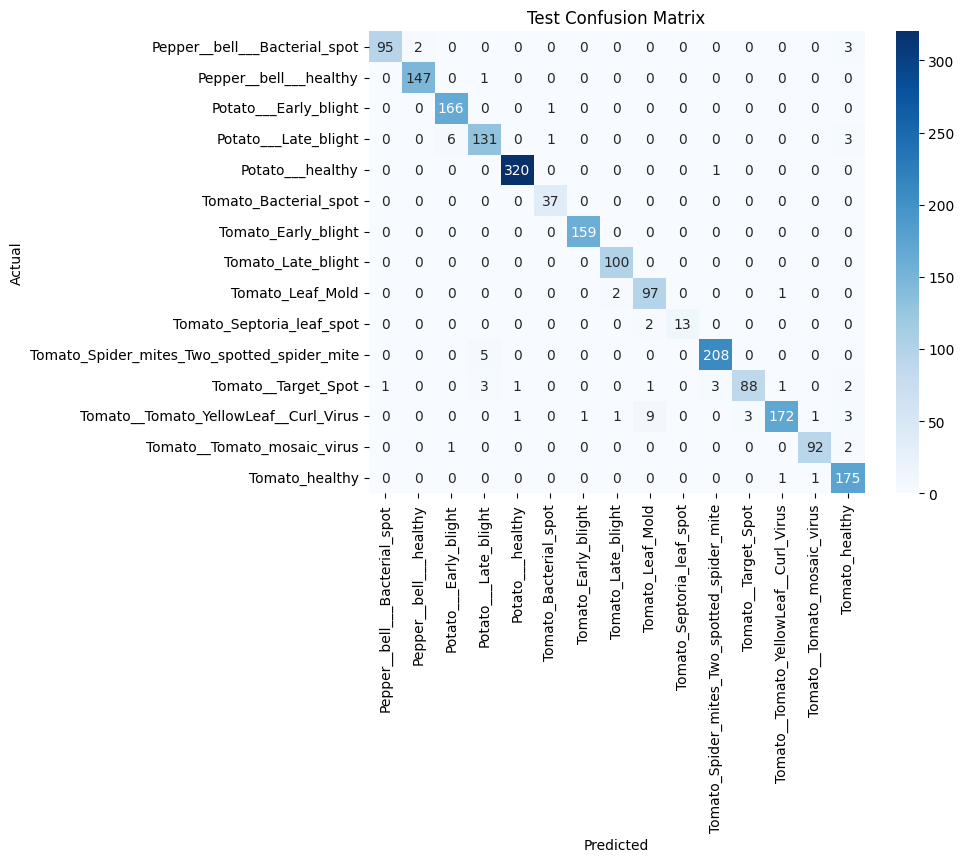

In [53]:
#Confusion matrix
cm_path = config.CNN_TEST_RESULTS_DIR / "confusion_matrix.png"
plot_confusion_matrix_cnn_test(y_true_labels, y_pred_labels, class_names, cm_path)
plt.show()

#### Confusion Matrix

We generate and display a confusion matrix to visualize how well the CNN model performs across each of the 15 plant disease and health classes. This matrix, saved as `confusion_matrix.png` in `/outputs/testing_results/CNN`, provides a breakdown of actual versus predicted labels on the test set.

From the matrix, we observe strong diagonal dominance, indicating accurate classification across most categories. Notably, classes like `Potato__healthy`, `Tomato_Spider_mites_Two_spotted_spider_mite`, and `Tomato__YellowLeaf__Curl_Virus` show particularly high correctness, suggesting the model confidently recognizes these leaf types. Misclassifications are minimal, and off-diagonal values are low, which supports the strong overall performance seen in the precision/recall metrics.


Prediction explanation grid saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\cnn\prediction_explanation_grid.png


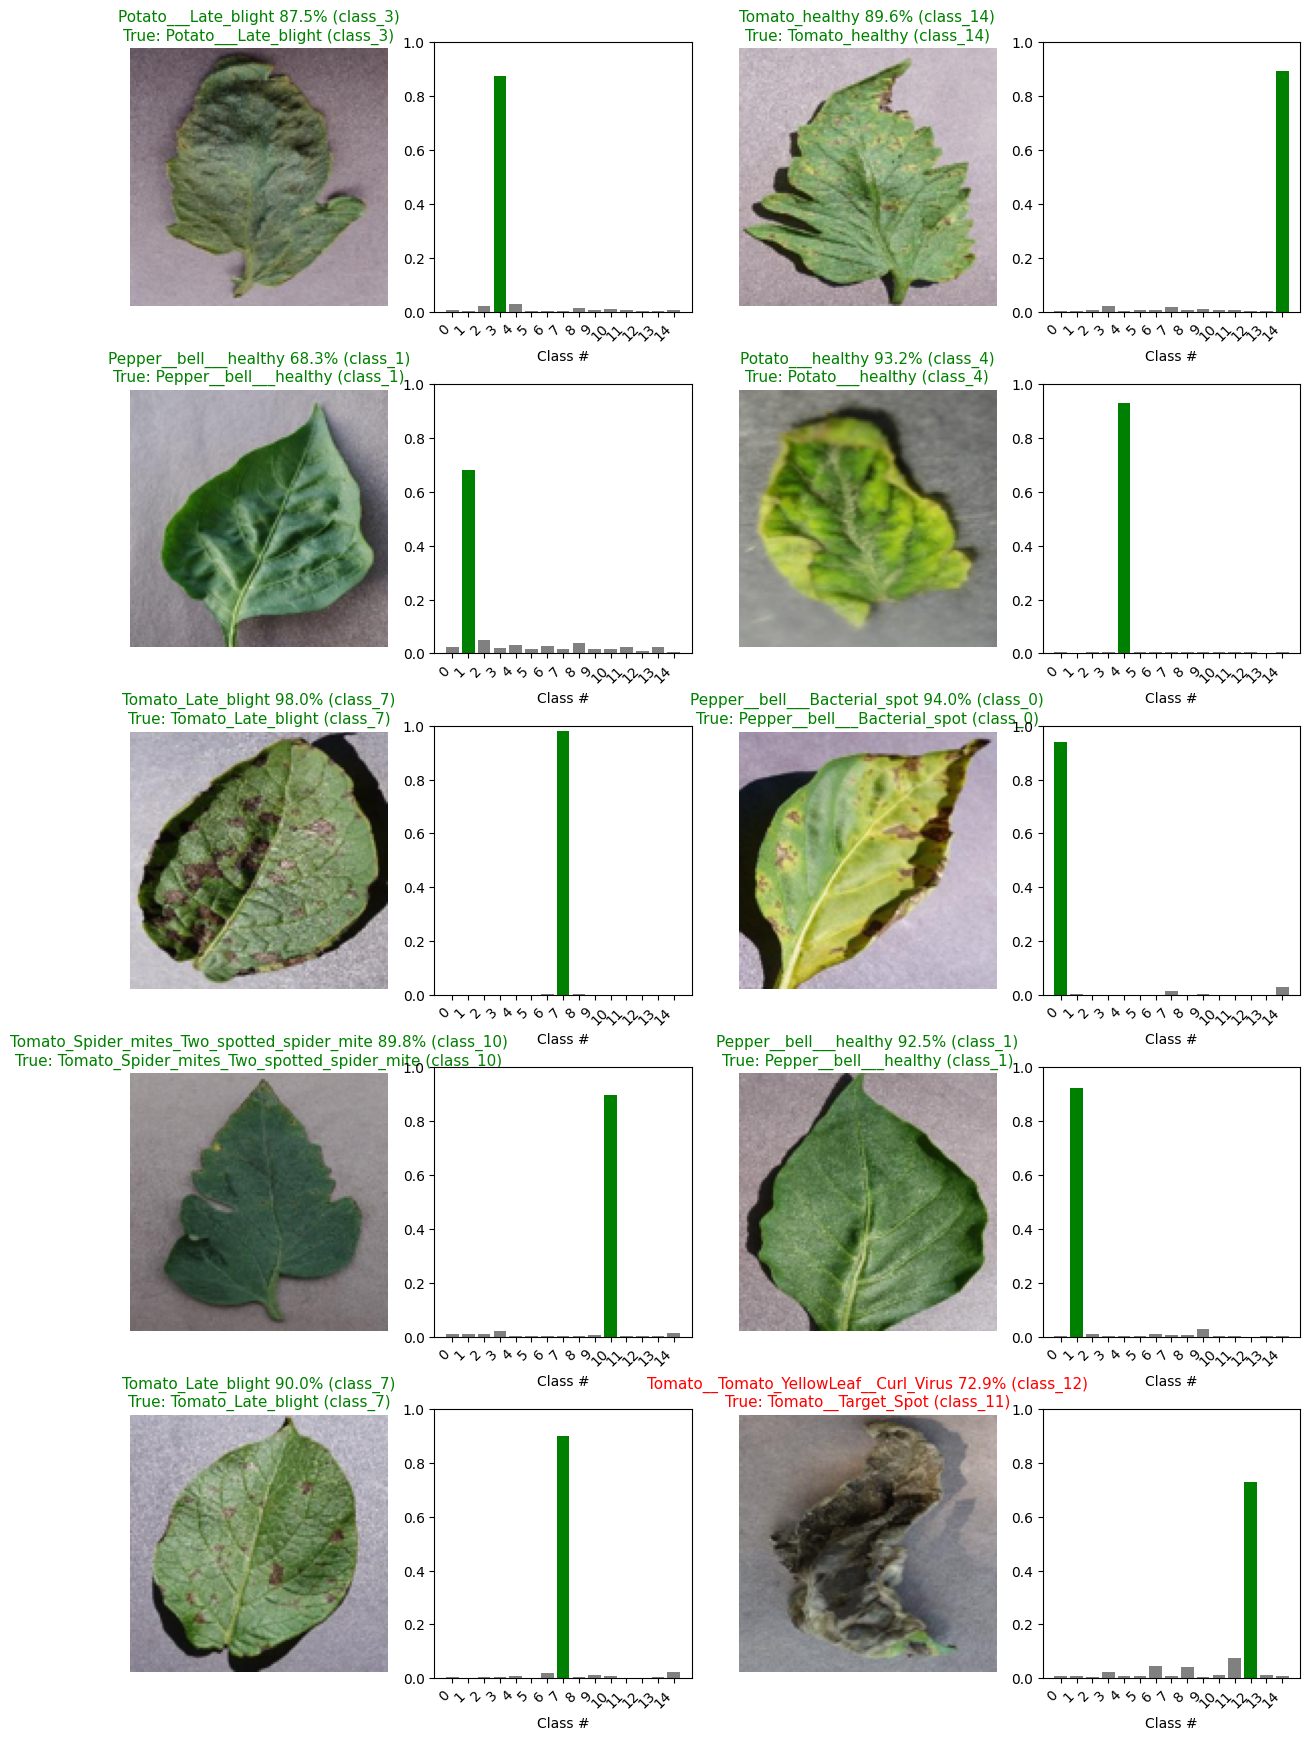

In [54]:
# Explanation grid
explanation_grid_path = config.CNN_TEST_RESULTS_DIR / "prediction_explanation_grid.png"
plot_prediction_explanation_grid(
    test_generator, y_pred_probs, y_pred_labels, class_names, explanation_grid_path, n_images=10
)

#### Visualize Predictions with Explanation Grid

We generate a prediction explanation grid using `plot_prediction_explanation_grid()`, saved as `prediction_explanation_grid.png` in `/outputs/testing_results/CNN`. This grid displays a selection of test images alongside their predicted labels, predicted confidence (as a probability bar chart), and ground truth labels.

Each row pairs a sample image with its corresponding probability distribution. The green bars show how confident the model is in its top prediction, while the label text indicates whether the prediction was correct. Most predictions show extremely high confidence with near-1.0 certainty, and visual inspection confirms accurate classifications in most cases.

In one misclassified example (`Tomato_YellowLeaf_Curl_Virus` predicted as `Tomato_Target_Spot`), we see how the model still exhibits high confidence despite the error. This highlights the importance of combining confidence metrics with deeper interpretability tools (like Grad-CAM) to better understand model behavior in borderline or visually similar classes.


Probabilities heatmap saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\cnn\probabilities_heatmap.png


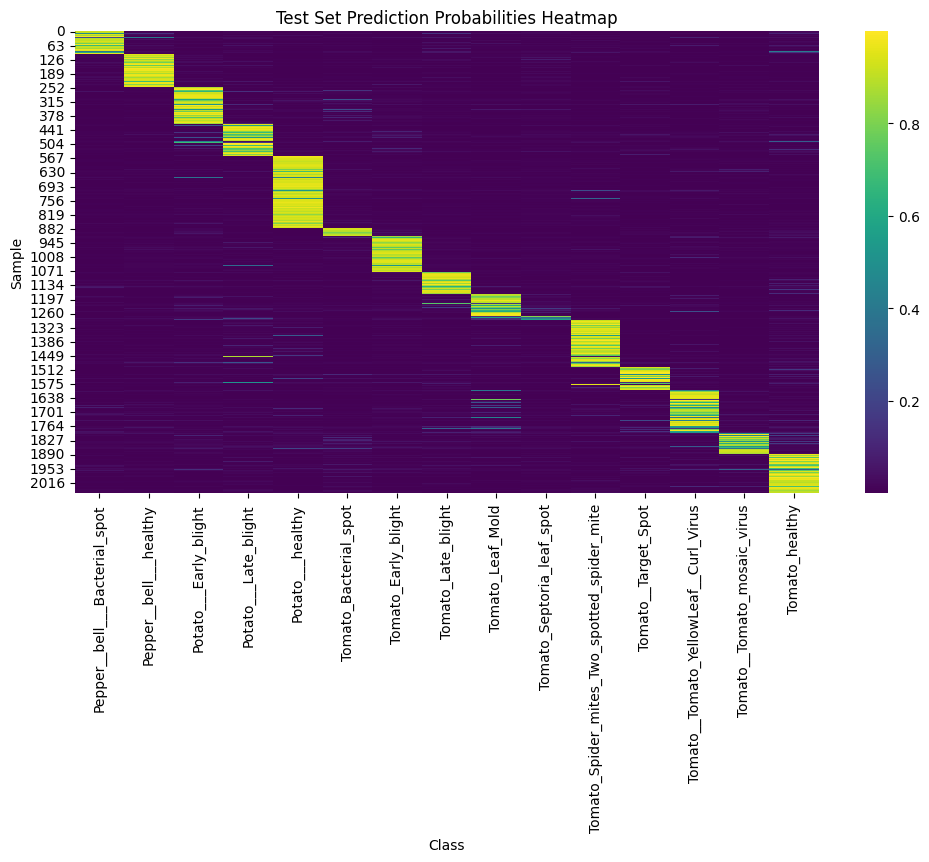

In [55]:
# Plot Prediction Probability Heatmap
proba_path = config.CNN_TEST_RESULTS_DIR / "probabilities_heatmap.png"
plot_cnn_probabilities_heatmap_test(y_pred_probs, proba_path, class_names=class_names)
plt.show()

#### Visualize Test Prediction Confidence with a Probability Heatmap

This heatmap shows the predicted class probabilities for each sample in the CNN test set, where rows represent individual samples and columns represent the 15 possible classes.

Each bright yellow vertical stripe along the diagonal represents high model confidence in the correct class — a sign of strong generalization. The cleaner and more focused the stripe, the more certain the model is in its prediction. Compared to the RF model's test heatmap (which showed more dispersed confidence), this CNN model displays much stronger class certainty with tighter, more distinct diagonal activation patterns.

While occasional horizontal streaks indicate confusion or lower confidence on some samples (notably around classes with overlapping symptoms), the overall pattern demonstrates that the model produces reliable and well-separated probability distributions on the test set.

In [56]:
# Display summary metrics
weighted_avg = cls_report.get("weighted avg", {})
print("\nWeighted Average Metrics (all classes):")
for metric, value in weighted_avg.items():
    print(f"{metric}: {value:.4f}")

print(f"\nROC-AUC (macro): {roc_auc:.4f}" if roc_auc is not None else "\nROC-AUC (macro): N/A")

print("Predicted label distribution:", np.bincount(y_pred_labels))
print("True label distribution:", np.bincount(y_true_labels))


Weighted Average Metrics (all classes):
precision: 0.9697
recall: 0.9690
f1-score: 0.9688
support: 2064.0000

ROC-AUC (macro): 0.9994
Predicted label distribution: [ 96 149 173 140 322  39 160 103 109  13 212  91 175  94 188]
True label distribution: [100 148 167 141 321  37 159 100 100  15 213 100 191  95 177]


#### Evaluate the Final CNN Model on the Test Set

The final CNN model was evaluated on a test set consisting of 2,064 leaf image samples. The model achieved a weighted average precision of ~0.9697, meaning that nearly 97% of its predicted class labels were correct when accounting for class frequency. The weighted recall was ~0.9690, indicating that the model correctly identified 96.9% of all true class instances. The weighted F1-score, which balances precision and recall, was ~0.9688—highlighting consistent and high-quality classification performance across all 15 categories.

The model also achieved a macro-averaged ROC-AUC score of ~0.9994, suggesting near-perfect class separability based on predicted probability distributions. This high AUC confirms that the model not only makes accurate predictions but also assigns well-calibrated confidence scores, even when evaluated under one-vs-rest conditions.

Additionally, the predicted label distribution aligns closely with the true label distribution, showing that the model handles class imbalance well and does not overfit to dominant classes. This reinforces the strength of the data preparation pipeline, which included stratified sampling, normalization, and well-balanced training strategies.

Overall, these results confirm that the CNN model demonstrates strong generalization to unseen data, with exceptional accuracy and reliability across all classes.


###### **\*** **Note:** All CNN test evaluation results, including classification report, confusion matrix, explanation grid, and prediction heatmaps, are saved to `/outputs/testing_results/CNN`.


#### Model Comparison

The Random Forest (RF) and Convolutional Neural Network (CNN) models were both evaluated on the same underlying test dataset of 2,064 plant disease images, but the way the data was handled for each model differed substantially. The RF model operated on flattened and compressed bottleneck features extracted via an autoencoder, while the CNN model processed raw images directly in their 2D spatial form.

The Random Forest model achieved a weighted F1-score of ~0.659 and a macro ROC AUC of ~0.942. These results reflect moderate classification performance, with some success in separating class distributions, but clear limitations in making accurate predictions—likely due to the information loss inherent in compressing image features into a low-dimensional bottleneck. Misclassifications were most common among disease categories with subtle visual differences, as seen in the confusion matrix.

On the other hand, the CNN model significantly outperformed the RF, achieving a weighted F1-score of ~0.9688 and a near-perfect macro ROC AUC of ~0.9994. The CNN benefited from learning directly from image data, allowing it to capture spatial hierarchies and textural features crucial for distinguishing between similar leaf diseases. It also demonstrated strong calibration, high confidence in its predictions, and minimal confusion across classes, as evidenced by sharp diagonal patterns in both the confusion matrix and probability heatmaps.

#### Model Limitations

While the CNN's performance was excellent, each model still comes with inherent limitations.

The Random Forest approach is limited by its reliance on compressed features, which can obscure critical image characteristics, and by its lack of inherent spatial awareness. Additionally, performance plateaus when using flat, non-hierarchical input in tasks where visual complexity matters.

The CNN, while highly accurate, is more resource-intensive, prone to overfitting without sufficient regularization, and less interpretable than tree-based models. Its performance is also tightly coupled to training image quality and augmentation strategies.

#### Next Steps

As a next step, we plan to introduce an XGBoost model trained on the same autoEncoder-derived bottleneck features used for the Random Forest. XGBoost may capture non-linearities and interactions more effectively than RF, potentially improving classification accuracy while retaining model interpretability.

In addition, we will experiment with model stacking, combining the CNN, Random Forest, and XGBoost predictions into a single ensemble. A meta-learner, such as logistic regression or another tree-based model, will be trained on the predicted probabilities from each base learner to optimize final predictions. This stacked ensemble may offer the best of both worlds—leveraging the CNN’s high accuracy and the tree-based models' robustness and interpretability—to further boost performance and stability across diverse image samples.

##### References (APA 7th Edition)

###### Analytics Vidhya. (2021, June 17). *Dimensionality reduction using autoencoders in Python*. https://www.analyticsvidhya.com/blog/2021/06/dimensionality-reduction-using-autoencoders-in-python/

###### GeeksforGeeks. (n.d.). *Dropout regularization in deep learning*. https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/

###### Iqbal, P. A. (n.d.). *Easily image data preparation with ImageDataGenerator in TensorFlow*. Medium. https://iqbalpa.medium.com/easily-image-data-preparation-with-imagedatagenerator-in-tensorflow-5fd75fb32bc2

###### Keras. (n.d.). *Model config serialization*. https://keras.io/api/models/model_saving_apis/model_config_serialization

###### Keras. (n.d.). *ReduceLROnPlateau callback*. https://keras.io/api/callbacks/reduce_lr_on_plateau/

###### Keras. (n.d.). *tf.keras.layers.Dense*. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

###### Keras. (n.d.). *tf.keras.activations.softmax*. https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax

###### Keras. (n.d.). *GlobalAveragePooling2D*. https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D

###### Keras. (n.d.). *BatchNormalization*. https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

###### Keras. (n.d.). *Grad-CAM Class Activation and Visualization*. https://keras.io/examples/vision/grad_cam

###### Kashyap, P. (2022, January). *Early stopping in deep learning: A simple guide to prevent overfitting*. Medium. https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e

###### Medium. (n.d.). *Bottleneck sizes and autoencoders*. https://medium.com/@tejpal.abhyuday/every-thing-about-autoencoders-efad99fdb8ba

###### Medium. (n.d.). *Clustering text data with K-Means and visualizing with t-SNE*. https://medium.com/@RobuRishabh/clustering-text-data-with-k-means-and-visualizing-with-t-sne-9bc1fe7d8fed

###### Medium. (n.d.). *EDA with autoencoders*. https://medium.com/@girishajmera/autoencoders-tsne-exploratory-data-analysis-on-unlabeled-image-dataset-3bdf499dbad3

###### Medium. (n.d.). *Fine-tuning transforms in PyTorch*. https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde

###### Medium. (n.d.). *Label smoothing explained*. https://medium.com/@amit25173/label-smoothing-explained-1b0f13754ae9

###### Medium. (n.d.). *PCA vs. autoencoders*. https://medium.com/data-science/dimensionality-reduction-with-autoencoders-versus-pca-f47666f80743

###### Python. (n.d.). *json — JSON encoder and decoder*. https://docs.python.org/3/library/json.html

###### PyImageSearch. (2020, March 9). *Grad-CAM: Visualize class activation maps with Keras, TensorFlow, and deep learning*. https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/

###### PyTorch. (n.d.). *Reproducibility*. https://pytorch.org/docs/stable/notes/randomness.html

###### Real Python. (n.d.). *Image processing with the Python Pillow library*. https://realpython.com/image-processing-with-the-python-pillow-library/

###### Scikit-learn. (n.d.). *SMOTETomek*. https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html

###### TensorFlow. (n.d.). *tf.keras.layers.GlobalAveragePooling2D*. https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D

###### TensorFlow. (n.d.). *tf.keras.layers.BatchNormalization*. https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

###### TTA for cell segmentation. (2020). *Scientific Reports, 10*(1), 1–12. https://www.nature.com/articles/s41598-020-61808-3

###### Understanding TTA. (2024). *arXiv preprint arXiv:2402.06892*. https://arxiv.org/html/2402.06892v1

###### Olamendy, J. C. (n.d.). *A comprehensive guide to Stratified K-Fold cross-validation for unbalanced data*. Medium. https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-stratified-k-fold-cross-validation-for-unbalanced-data-014691060f17

###### Srivastav, S. (n.d.). *Understanding t-SNE: A powerful technique for visualising high-dimensional data*. Medium. https://medium.com/@shreyasrivastav26/understanding-t-sne-a-powerful-technique-for-visualising-high-dimensional-data-7df77bf0b408
